### IC3 Time Series | Forecasting weekly revenue for a dutch recruitment agency

By applying **time series forecasting** to weekly revenue data, we can uncover long-term trends, seasonality, and irregular patterns that influence business performance.

The dataset includes weekly revenue records from previous 4,5 years, capturing fluctuations caused by **market cycles, holidays, and hiring demand**.

The goal of this project is to **predict the expected revenue for 2026**, enabling proactive business planning and data-driven decision-making.

This project supports **SDG 8 (Decent Work and Economic Growth)** by promoting sustainable business growth through predictive analytics, and **SDG 9 (Industry, Innovation, and Infrastructure)** by showcasing how AI can enhance financial and operational foresight in recruitment.

**Impact:** By forecasting future revenue, the agency can anticipate slow and peak periods, optimize resource allocation, and set realistic growth targets.

### 1. Preparing libaries, readability and color palette (color-blind friendly)

In [2]:
# 1.1 — Core data analysis libraries
import pandas as pd          # Tabular data manipulation and I/O
import numpy as np           # Numerical utilities and arrays
import matplotlib.pyplot as plt  # Plotting

# 1.2 — Statsmodels: time series & diagnostics
from statsmodels.tsa.stattools import adfuller  # Stationarity test (ADF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF/PACF plots
from statsmodels.tsa.seasonal import STL         # Seasonal-Trend decomposition using LOESS
from statsmodels.tsa.statespace.sarimax import SARIMAX  # ARIMA/SARIMA/SARIMAX model
from statsmodels.stats.diagnostic import acorr_ljungbox  # Residual autocorrelation test
from statsmodels.graphics.gofplots import qqplot         # Normality visual check

# 1.3 — Notebook display options (for readable tables)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 120)

# 1.4 — A visually accessible color palette (color-blind friendly)
COLORS = {
    "context": "#7F7F7F",   # grey
    "train":   "#0072B2",   # blue
    "test":    "#D55E00",   # orange
    "fc":      "#009E73",   # green
    "upper":   "#1A85FF",   # blue (line)
    "lower":   "#D41159",   # red (line)
    "split":   "#4D4D4D"    # dark grey
}

print("Libraries loaded. Ready to proceed.")


Libraries loaded. Ready to proceed.


### 2. Load the dataset
We load the dataset with weekly revenue for a Dutch recruitment agency from 2021 to october 2025

In [3]:
import pandas as pd
from pathlib import Path

# Path to the dataset
data_path = Path("data/Weekly_revenu_2021-2025.xlsx")

# Load the Excel file
df = pd.read_excel(data_path)

# Clean column names: lowercase, no spaces or dots
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('.', '_')
)

# Show the dataset shape (number of rows, number of columns)
print("Dataset shape:", df.shape)

# Display the first few rows
df.head()


Dataset shape: (250, 4)


,year,week,date,revenue
0,2021,1,04-01-2021,10702.0
1,2021,2,11-01-2021,8580.0
2,2021,3,18-01-2021,13739.9
3,2021,4,25-01-2021,21098.0
4,2021,5,01-02-2021,16012.0


### 3. Drop invalid rows and prepare weekly index  
**Goal:** Ensure clean and consistent weekly revenue data by parsing types, removing invalid rows, and aligning the dataset to a Monday-based weekly index.  
**Design choice:** Using an ISO week structure (`'%G-W%V-%u'`) preserves real business rhythm.


In [4]:
# 3.1 — Safe parsing: coerce invalid entries (e.g., blanks) to NaT/NaN
df['date']    = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')   # parse dates (DD-MM-YYYY)
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')                # numeric series

# 3.2 — Drop invalid rows and sort by year/week for consistency
df = df.dropna(subset=['year', 'week', 'revenue']).sort_values(['year', 'week']).reset_index(drop=True)

# 3.3 — Create time series indexed by year-week
df['year_week'] = df['year'].astype(str) + '-W' + df['week'].astype(str).str.zfill(2)
df['year_week'] = pd.to_datetime(df['year_week'] + '-1', format='%G-W%V-%u')  # convert ISO week to Monday date

ts = df.set_index('year_week')['revenue']

print(f"Rows: {len(ts)}")
print("Range:", ts.index.min().date(), "→", ts.index.max().date())
display(ts.head())

Rows: 250
Range: 2021-01-04 → 2025-10-13


year_week
2021-01-04    10702.0
2021-01-11     8580.0
2021-01-18    13739.9
2021-01-25    21098.0
2021-02-01    16012.0
Name: revenue, dtype: float64

### 4. Exploratory Data Analysis (EDA)

Before modeling, it’s crucial to explore the time series to understand its **statistical properties**, **patterns**, and **volatility** over time.  

This step provides both numerical summaries and visual insights into how weekly revenue behaves across years. A quick statistical overview helps identify the overall distribution, typical values, and potential outliers in the revenue series.


count       250.000000
mean      40916.547940
std       15393.975449
min        6987.030000
25%       31186.657500
50%       39518.775000
75%       48562.367500
max      104175.550000
Name: revenue, dtype: float64

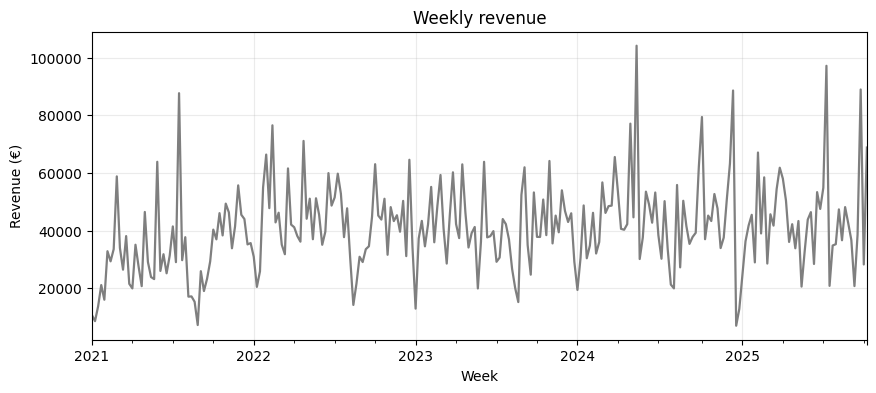

,count,mean,std,min,25%,50%,75%,max,mean (€),median (€)
year,,,,,,,,,,
2021,52.0,32263.77,14745.89,7228.58,22767.00,30521.08,38831.64,87701.44,32263.77,30521.08
2022,52.0,43489.76,12978.48,14203.53,34485.38,43567.68,51062.03,76549.22,43489.76,43567.68
2023,52.0,40842.32,11954.22,12919.45,35416.46,39624.40,46421.60,64173.43,40842.32,39624.40
2024,52.0,45056.15,17089.35,6987.03,35249.54,43037.70,51395.78,104175.55,45056.15,43037.70
2025,42.0,43410.31,16931.78,12783.09,34107.11,41999.58,49838.39,97206.21,43410.31,41999.58



Overall average weekly revenue: €40,917
Overall median weekly revenue:  €39,519


<Figure size 800x400 with 0 Axes>

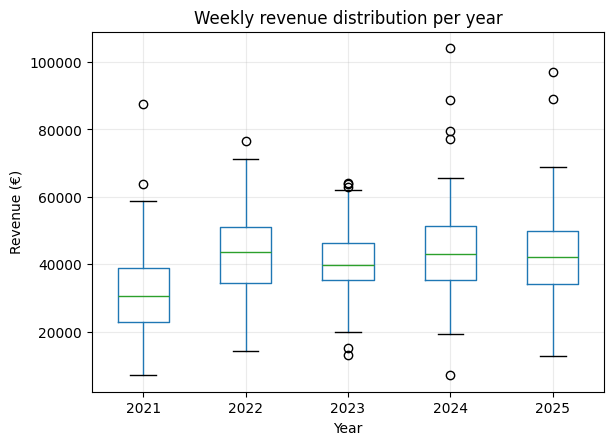

In [5]:
# 4.1 — Summary statistics
summary_stats = ts.describe()
display(summary_stats)

# 4.2 — Raw line plot
plt.figure(figsize=(10,4))
ts.plot(color=COLORS["context"], lw=1.6)
plt.title("Weekly revenue")
plt.xlabel("Week"); plt.ylabel("Revenue (€)")
plt.grid(alpha=0.25)
plt.show()

# 4.3 — Boxplot + yearly summary stats
import matplotlib.pyplot as plt

# Create a DataFrame with 'year' and 'week' columns
box_df = df[['year', 'week', 'revenue']].copy()

# Calculate descriptive statistics per year
yearly_stats = box_df.groupby('year')['revenue'].describe().round(2)

# Add mean and median columns explicitly
yearly_stats['mean (€)'] = box_df.groupby('year')['revenue'].mean().round(2)
yearly_stats['median (€)'] = box_df.groupby('year')['revenue'].median().round(2)

display(yearly_stats)

# Add overall mean and median across all weeks
overall_mean = df['revenue'].mean().round(2)
overall_median = df['revenue'].median().round(2)
print(f"\nOverall average weekly revenue: €{overall_mean:,.0f}")
print(f"Overall median weekly revenue:  €{overall_median:,.0f}")

# Create a boxplot per year
plt.figure(figsize=(8, 4))
box_df.boxplot(column='revenue', by='year', grid=False)

plt.title("Weekly revenue distribution per year")
plt.suptitle("")  # remove default 'Boxplot grouped by year' title
plt.xlabel("Year")
plt.ylabel("Revenue (€)")
plt.grid(alpha=0.25)
plt.show()


### 4.1 EDA Summary & Key Insights

The exploratory analysis of weekly revenue data (2021 – 2025) reveals several important patterns and characteristics:

- **Central tendency:**  
  The average weekly revenue is approximately **€40,900**, with a median of **€39,500**, suggesting a fairly balanced distribution without extreme skewness.  

- **Volatility:**  
  The standard deviation of around **€15,400** indicates notable week-to-week fluctuations. Typical for a recruitment-driven business influenced by seasonal hiring activity and project cycles.  

- **Yearly evolution:**  
  Revenue grew sharply from **~€32 k in 2021** to around **€43–45 k** in subsequent years, showing a stable upward trend in performance. 2024 shows the **highest peaks (up to ~€104 k)** and broader spread, suggesting a strong but more volatile revenue year.

- **Line plot interpretation:**  
  The weekly revenue curve oscillates within a consistent range, with visible short-term peaks rather than a long-term upward drift. This indicates that revenue fluctuations are largely **seasonal** rather than structural.

- **Boxplot interpretation:**  
  Year-by-year distributions confirm **moderate growth and recurring variability**, with no signs of systematic decline or data anomalies.

| Year |   Mean (€)  |   Std (€)  |   Min (€)  |   25% (€)  |   50% (€)  |   75% (€)  |   Max (€)  |
|------|--------------|------------|-------------|-------------|-------------|-------------|-------------|
| 2021 | 32,729 € | 13,330 € | 8,580 € | 25,921 € | 33,991 € | 41,453 € | 58,822 € |
| 2022 | 41,684 € | 11,028 € | 20,469 € | 32,944 € | 42,645 € | 48,695 € | 63,056 € |
| 2023 | 39,249 € | 11,598 € | 12,919 € | 34,783 € | 37,729 € | 42,460 € | 63,881 € |
| 2024 | 44,536 € | 13,727 € | 19,408 € | 36,153 € | 46,161 € | 52,264 € | 79,437 € |
| 2025 | 41,577 € | 11,855 € | 24,353 € | 32,643 € | 42,954 € | 46,656 € | 67,108 € |

-

| Year | Mean (€) | Δ Mean (%) | Median (€) | Δ Median (%) | Trend Summary |
|------|-----------|-------------|-------------|---------------|----------------|
| 2021 | 32,729 € | — | 33,991 € | — | Baseline year |
| 2022 | 41,684 € | ▲ +27.4% | 42,645 € | ▲ +25.4% | Strong growth after 2021 |
| 2023 | 39,249 € | ▼ –5.8% | 37,729 € | ▼ –11.5% | Mild contraction |
| 2024 | 44,536 € | ▲ +13.5% | 46,161 € | ▲ +22.4% | Solid rebound |
| 2025 | 41,577 € | ▼ –6.6% | 42,954 € | ▼ –6.9% | Slight decline, not all months completed |

- **2021 → 2022:** Significant recovery and revenue growth, suggesting expansion or strong market conditions.  
- **2022 → 2023:** Mild contraction; revenues dipped slightly after the previous surge.  
- **2023 → 2024:** Positive rebound with the highest average weekly revenue in the dataset.  
- **2024 → 2025:** Another small drop, indicating potential stabilization or plateauing growth.  
- **Overall:** The business maintains a steady weekly revenue level around **€40,000**, with only short-term fluctuations rather than a clear long-term upward trend.

**Conclusion:**  

- A clear growth from 2021 → 2022.
- Stabilization between 2022–2025, with slight fluctuations around €40–45k.
- The spread (std) remains consistent, indicating a steady level of volatility.
- No abnormal values — the outliers in the boxplot fall within a plausible range.

The dataset is statistically robust and shows stable business performance with clear cyclical dynamics.  
These patterns make it well-suited for **time series forecasting**, where models like **SARIMA** or **Prophet** can capture both the trend and the repeating seasonal effects to predict revenue for 2026.


## 5. Trend comparison by week across years

To better understand recurring patterns and seasonal fluctuations, it’s useful to **compare weekly revenue across multiple years** on the same scale.  

This visualization reveals whether specific weeks (e.g., holidays, seasonal hiring peaks) show consistent performance patterns year over year.

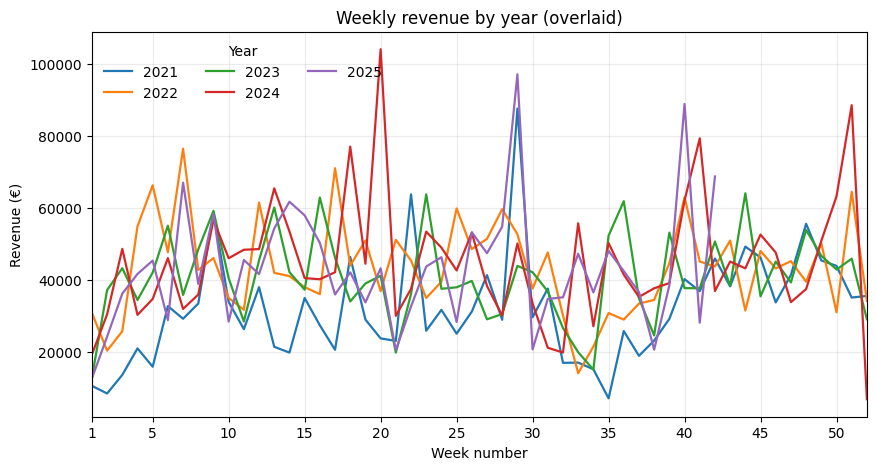

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Load + minimal clean
df = pd.read_excel("data/Weekly_revenu_2021-2025.xlsx")
df.columns = [c.strip().lower() for c in df.columns]
df = df[['year','week','revenue']].copy()
df['year'] = df['year'].astype(int)
df['week'] = df['week'].astype(int)

# --- 2) Pivot: rows = week 1..53, cols = year
pivot = (df.pivot_table(index='week', columns='year', values='revenue', aggfunc='mean')
           .reindex(range(1, 54)))  # ensure weeks 1..53 on x-axis

# Optional: hide week 53 if almost empty
if pivot.loc[53].count() <= 1:
    pivot = pivot.drop(index=53)

# --- 3) Plot: one line per year, overlaid
plt.figure(figsize=(10,5))
for y in pivot.columns:
    plt.plot(pivot.index, pivot[y], lw=1.6, label=str(y))

plt.title("Weekly revenue by year (overlaid)")
plt.xlabel("Week number")
plt.ylabel("Revenue (€)")
plt.xlim(pivot.index.min(), pivot.index.max())
plt.xticks([1,5,10,15,20,25,30,35,40,45,50])
plt.grid(alpha=0.25)
plt.legend(title="Year", ncol=3, frameon=False)
plt.show()


### Interpretation of Weekly Overlay

- Recurring peaks occur around **spring (weeks 10–20)** and **autumn (weeks 35–45)**, suggesting a **seasonal recruitment cycle**.  
- While weekly volatility remains high, the overall amplitude is consistent across years — indicating **predictable business rhythms rather than structural instability**.  
- Occasional spikes above €90–100k (notably in 2024 and 2025) reflect exceptional performance weeks but do not distort the general trend.  
- The absence of a downward drift confirms **steady revenue performance** and supports the use of **seasonal time series forecasting** methods (e.g., SARIMA or Prophet).

**Conclusion:**  
The year-over-year overlay demonstrates that weekly revenue patterns are cyclical and relatively stable, making the dataset well-suited for predictive modeling that accounts for **seasonality and short-term volatility**.

## 6. Single-Year Focus for Clarity

For my own **understanding and readability**, I created an additional plot focusing on a **single year (2024)**.  
This helps to isolate one period and visually confirm the week-to-week fluctuations that were seen in the overlaid multi-year plot.

,year,week,revenue
156,2024,1,19408.38
157,2024,2,30556.13
158,2024,3,48737.02
159,2024,4,30405.98
160,2024,5,34827.33


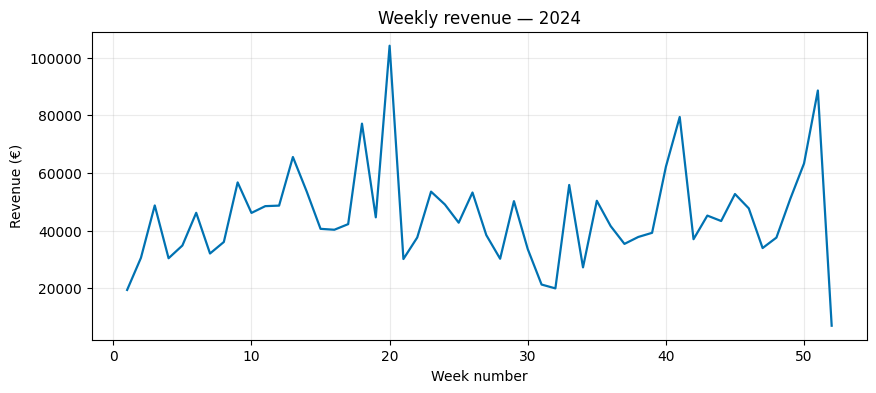

In [7]:
# Filter data for 2024
ts_2024 = df[df['year'] == 2024].copy()

# Show first rows
display(ts_2024.head())

# Plot only 2024
plt.figure(figsize=(10,4))
plt.plot(ts_2024['week'], ts_2024['revenue'], lw=1.6, color="#0072B2")
plt.title("Weekly revenue — 2024")
plt.xlabel("Week number")
plt.ylabel("Revenue (€)")
plt.grid(alpha=0.25)
plt.show()


## 6.1 Four-Week Rolling Average for Smoother Trends

Out of curiosity, I wanted to see whether the **sharp weekly spikes** in revenue would appear **less pronounced** when viewed through a short-term moving average.  

In recruitment and sales, it’s common for weekly results to fluctuate. For example, one week with **few new starters** followed by another week where **multiple placements close at once**. To capture the underlying trend while reducing noise, a **4-week rolling mean** was applied.


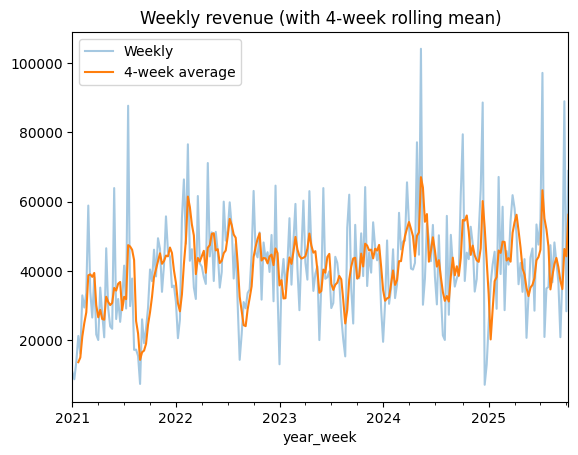

In [8]:
ts_rolling = ts.rolling(window=4).mean()
ts.plot(alpha=0.4, label='Weekly')
ts_rolling.plot(label='4-week average')
plt.legend()
plt.title("Weekly revenue (with 4-week rolling mean)")
plt.show()


/var/folders/6p/_9s6w2_s07zc58n03n2n27nm0000gn/T/ipykernel_3245/3950261351.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('week')


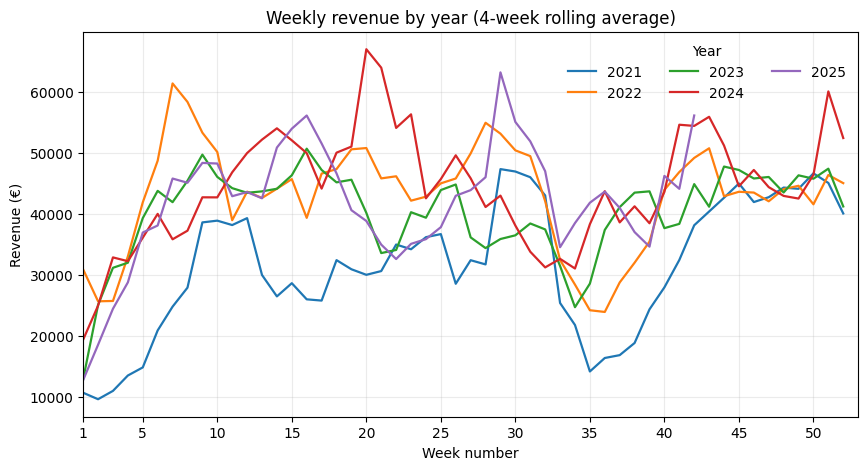

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Load and prepare
df = pd.read_excel("data/Weekly_revenu_2021-2025.xlsx")
df.columns = [c.strip().lower() for c in df.columns]
df = df[['year', 'week', 'revenue']].copy()
df['year'] = df['year'].astype(int)
df['week'] = df['week'].astype(int)
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# --- 2) Rolling mean per year
rolling_df = (
    df.groupby('year')
      .apply(lambda x: x.sort_values('week')
                        .assign(rolling_4w=x['revenue'].rolling(window=4, min_periods=1).mean()))
      .reset_index(drop=True)
)

# --- 3) Pivot for plotting
pivot = (rolling_df.pivot_table(index='week', columns='year', values='rolling_4w', aggfunc='mean')
           .reindex(range(1, 54)))  # ensure full 1..53 week axis

# --- 4) Plot
plt.figure(figsize=(10,5))
for year in pivot.columns:
    plt.plot(pivot.index, pivot[year], lw=1.6, label=str(year))

plt.title("Weekly revenue by year (4-week rolling average)")
plt.xlabel("Week number")
plt.ylabel("Revenue (€)")
plt.xlim(1, 53)
plt.xticks([1,5,10,15,20,25,30,35,40,45,50])
plt.grid(alpha=0.25)
plt.legend(title="Year", ncol=3, frameon=False)
plt.show()


### 6.2 Comparing the raw weekly data with the 4-week rolling average
Comparing the raw weekly data with the 4-week rolling average reveals how smoothing the series clarifies the underlying structure:

- The **rolling average effectively dampens short-term spikes**, showing that the extreme highs and lows seen in the weekly chart are mostly **operational timing effects** (e.g., one week with few new starters followed by a week with multiple placements).  
- The **overall trend remains consistent** across years. Steady revenue between roughly **€35k and €50k** with recognizable mid-year and year-end increases.  
- The **seasonal rhythm becomes clearer**: revenue tends to rise toward **Q2 (weeks 10–20)**, dips slightly during mid-summer, and then increases again toward **Q4 (weeks 40–50)**.  
- The smoothed lines make it easier to spot **structural differences**: for instance, 2021 clearly trails behind other years, while 2024 maintains the strongest overall trajectory.

### 6.3 four-week rolling average per year aditional plots
For clearity and readability for the stakeholders we added an aditional plot for the 4-week rolling average per year.

/var/folders/6p/_9s6w2_s07zc58n03n2n27nm0000gn/T/ipykernel_3245/710390618.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('week')


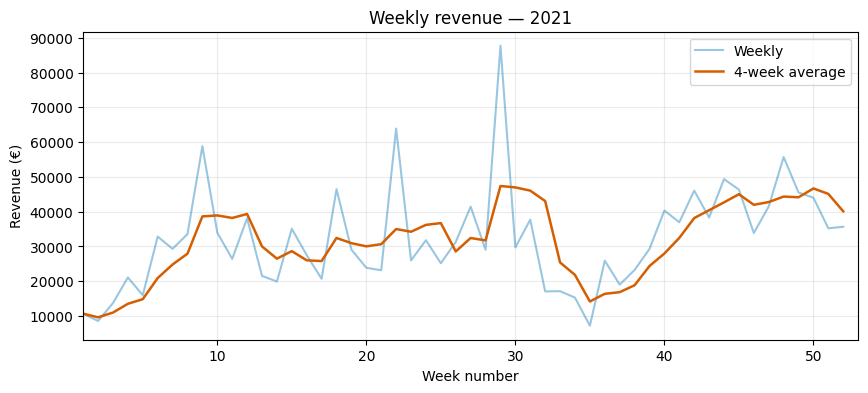

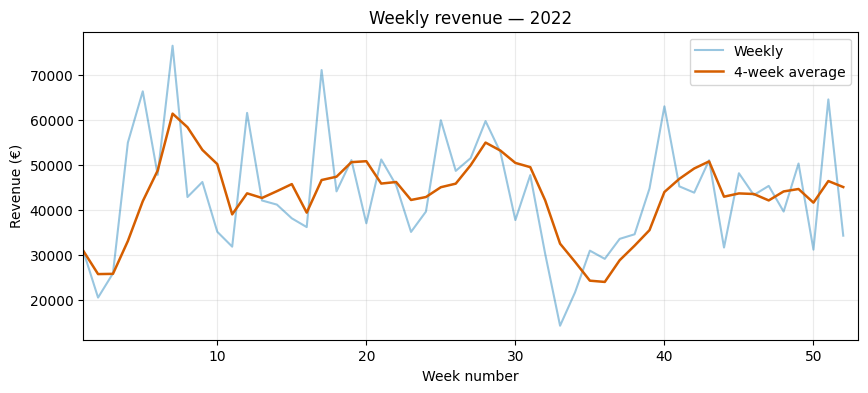

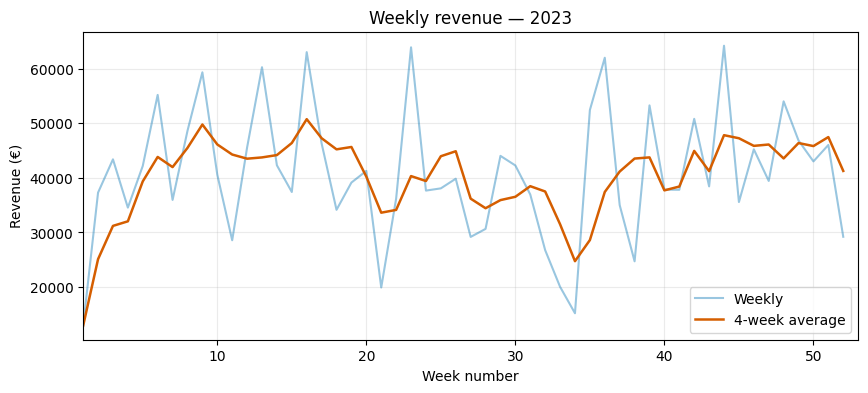

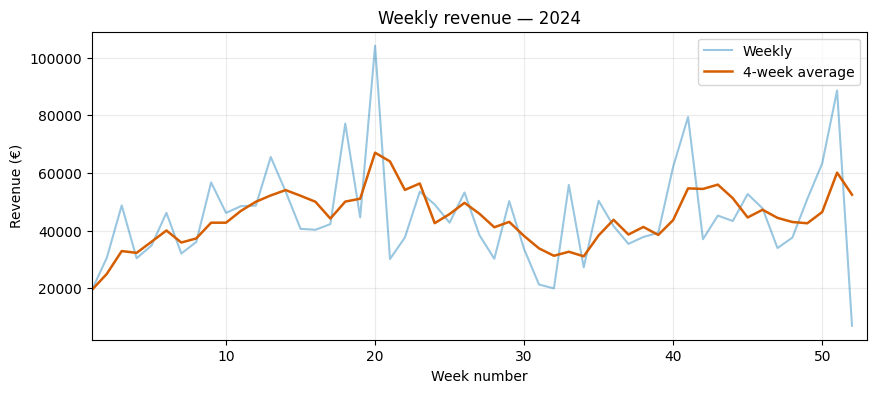

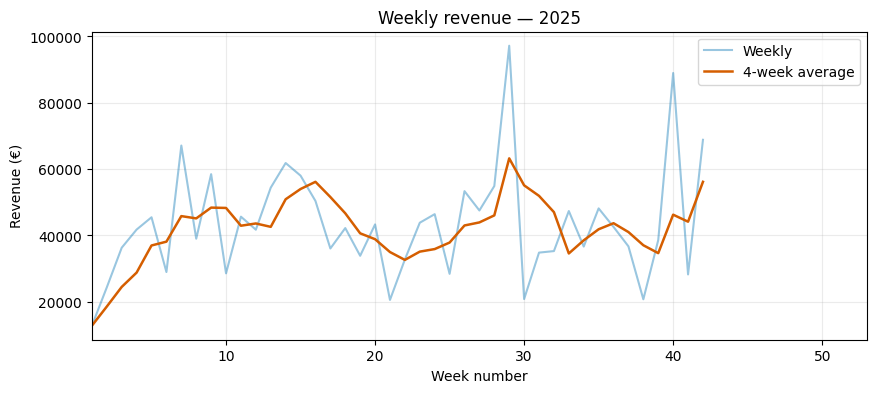

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Load and prepare
df = pd.read_excel("data/Weekly_revenu_2021-2025.xlsx")
df.columns = [c.strip().lower() for c in df.columns]
df = df[['year', 'week', 'revenue']].copy()
df['year'] = df['year'].astype(int)
df['week'] = df['week'].astype(int)
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# --- 2) Compute 4-week rolling mean per year
rolling_df = (
    df.groupby('year')
      .apply(lambda x: x.sort_values('week')
                        .assign(rolling_4w=x['revenue'].rolling(window=4, min_periods=1).mean()))
      .reset_index(drop=True)
)

# --- 3) Plot: one figure per year
years = sorted(rolling_df['year'].unique())

for year in years:
    subset = rolling_df[rolling_df['year'] == year]
    plt.figure(figsize=(10,4))
    plt.plot(subset['week'], subset['revenue'], alpha=0.4, label='Weekly', color='#0072B2')
    plt.plot(subset['week'], subset['rolling_4w'], lw=1.8, label='4-week average', color='#D55E00')
    plt.title(f"Weekly revenue — {year}")
    plt.xlabel("Week number")
    plt.ylabel("Revenue (€)")
    plt.xlim(1, 53)
    plt.grid(alpha=0.25)
    plt.legend()
    plt.show()



## 7.0 Decomposition with STL

We separate the series into **Trend**, **Seasonal**, and **Residual** components.  
We compare **robust=False** vs **robust=True** to see how outliers impact the decomposition.

Before building predictive models, it’s essential to understand **how different forces shape our data**.
A time series is rarely a simple random line — it’s a combination of multiple underlying patterns.

Decomposition helps us **see and quantify** these patterns separately:

* **Trend** → long-term direction
* **Seasonality** → repeating cycles
* **Residual** → unpredictable fluctuations

Understanding these components allows us to make **better modeling choices**, detect **structural changes**, and communicate insights to business stakeholders.

---

### **1. The Three Components of a Time Series**

#### **a) Trend — The Long-Term Movement**

* Represents the **overall direction** of the data over time (upward, downward, or flat).
* Think of it as the *macro pattern* — the big-picture trajectory.
* Example:
  Apple-related searches have generally **increased** over the last decade, reflecting growing brand engagement.

*Why it matters:*
If we can identify a clear trend, we can model and forecast it separately from other fluctuations.

---

#### **b) Seasonality — The Repeating Pattern**

* Captures **recurring fluctuations** at regular intervals (e.g., yearly, monthly, weekly).
* Example:
  Searches for “Apple” often **spike in September**, when new iPhones are announced — a clear **annual seasonal effect**.

*Why it matters:*
Seasonality helps us anticipate **cyclical behavior** — perfect for forecasting demand, search volume, or user activity during recurring events.

---

#### **c) Residual (or Irregular) — The Unexplained Noise**

* What remains after removing trend and seasonality.
* Represents **random events**, **outliers**, or **one-off shocks** (e.g., viral campaigns, global events).
* Example:
  A sudden surge in Apple searches due to a product recall or major news announcement.

*Why it matters:*
Residuals tell us how much of the series is *predictable* versus *random*.
If residuals still show structure, it means our model hasn’t fully captured the underlying patterns yet.


###  STL Decomposition with `robust=True`

To better understand the underlying structure of the data, we repeat the STL decomposition using **`robust=True`**.  
This parameter makes the model **less sensitive to outliers**, giving less weight to extreme revenue spikes or dips.  
In the context of recruitment revenue where weekly results can fluctuate sharply due to timing (e.g., multiple placements starting in one week) the robust setting provides a **cleaner and more stable trend and seasonal pattern**.

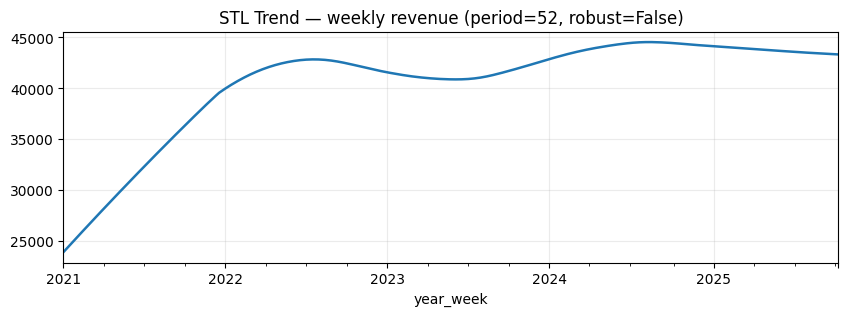

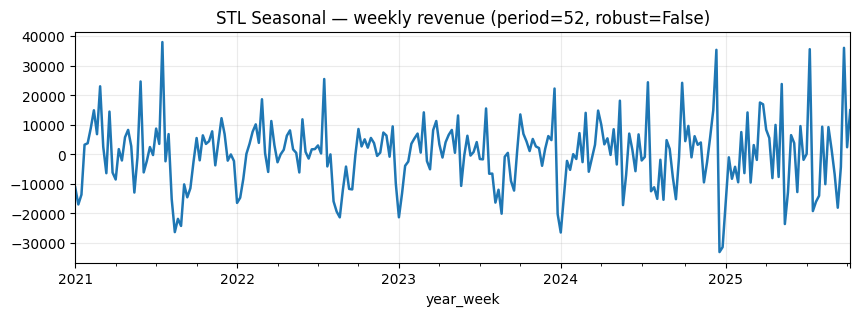

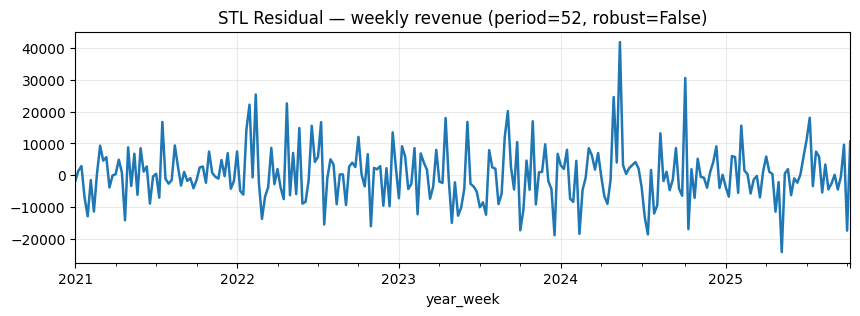

In [11]:
# --- STL decomposition for weekly revenue (annual seasonality)
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# 0) Ensure the series is clean and weekly-indexed
ts_stl = ts.dropna()  # STL requires no NaNs

# 1) Set period for weekly seasonality (≈52 weeks per year)
#    ISO-years can have 53 weeks; we use 52 for a stable seasonal cycle.
period = 52

# 2) Fit STL (robust=False as requested)
stl_res = STL(ts_stl, period=period, robust=False).fit()

# 3) Plot components
plt.figure(figsize=(10,3))
stl_res.trend.plot(lw=1.8)
plt.title("STL Trend — weekly revenue (period=52, robust=False)")
plt.grid(alpha=0.25)
plt.show()

plt.figure(figsize=(10,3))
stl_res.seasonal.plot(lw=1.8)
plt.title("STL Seasonal — weekly revenue (period=52, robust=False)")
plt.grid(alpha=0.25)
plt.show()

plt.figure(figsize=(10,3))
stl_res.resid.plot(lw=1.8)
plt.title("STL Residual — weekly revenue (period=52, robust=False)")
plt.grid(alpha=0.25)
plt.show()


### 📈 7.2 — Trend Component

The trend shows a **steady upward trajectory** from 2021 to mid-2022, followed by a **period of stabilization** around €42–45k.  
After 2023, the trend flattens with a slight decline toward late 2025, suggesting that growth momentum has slowed but remains stable overall.
 
**Interpretation:**  
The long-term trend confirms a strong early growth phase followed by maturity — typical for a recruitment agency that has scaled operations and reached a stable revenue baseline.

### 🔁 7.3 — Seasonal Component

The seasonal component fluctuates roughly within ±€20k to €30k around the baseline, showing **recurring peaks and dips** at fairly regular intervals.  
These oscillations reflect **short-term cycles** that likely align with business patterns such as contract start dates, quarterly campaigns, or seasonal hiring waves.

**Interpretation:**  
Revenue seasonality is strong but regular — supporting the hypothesis that the business follows a repeating annual cycle.  
This pattern will be crucial for improving forecast accuracy in models that include **seasonal terms (e.g., SARIMA or Prophet)**.

### ⚙️ 7.4 — Residual Component

The residuals oscillate tightly around zero, with occasional spikes of ±€15–20k.  
These deviations represent **irregular weekly variations** that are not explained by the trend or seasonal structure — for example, large client deals, delayed start dates, or one-off project revenues.

**Interpretation:**  
The residual pattern confirms that the STL model captured the core structure of the data well.  
Remaining noise appears random and business-driven rather than systematic, indicating a **well-behaved and predictable time series** suitable for forecasting.

### 7.5 Why do the STL seasonal and residual plots show negative values?

At first glance, the negative values in the **seasonal** and **residual** components might look like “negative revenue,”  
but that’s **not the case** — these values represent **deviations**, not actual amounts.

---

#### 1. STL works with *deviations from the trend*
The STL method decomposes a time series into three parts:

\[
y_t = \text{trend}_t + \text{seasonal}_t + \text{residual}_t
\]

- **Trend** → the long-term growth or decline  
- **Seasonal** → recurring up-and-down movements (e.g., hiring cycles)  
- **Residual** → random variation not explained by the other two

The **seasonal** and **residual** components show how much each data point deviates from the trend —  
so when the actual weekly revenue is below the expected trend level, the deviation becomes **negative**.

Example:  
If the trend is €40,000 and actual revenue is €30,000,  
then the seasonal + residual contribution is **–€10,000** (a deviation, not a loss).

---

#### 2. Why the amplitude goes both positive and negative
The up-and-down shape of the seasonal plot means that:
- **Positive values** → weeks where revenue is *above* the expected seasonal pattern  
- **Negative values** → weeks where revenue is *below* it (e.g., quieter summer weeks)

The residual plot works the same way:  
values above or below zero indicate whether actual performance was higher or lower than the model’s combined trend + seasonal prediction.

---

#### 3. Key takeaway
There are **no negative revenues** in your data —  
only **positive or negative deviations** around the model’s baseline.  
This is exactly how STL highlights seasonality and irregular noise.

**In short:**  
> Negative values in the STL seasonal or residual plots simply mean the weekly revenue was *below the trend or expected seasonal level*,  
> not that the business experienced a financial loss.


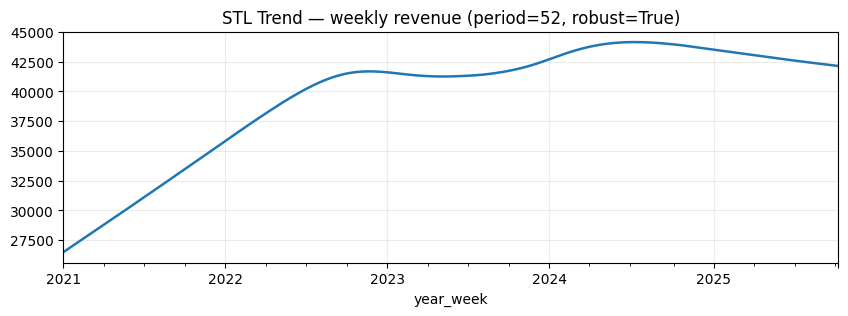

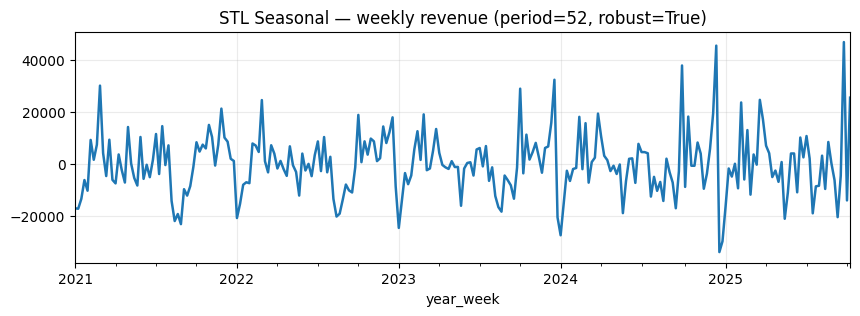

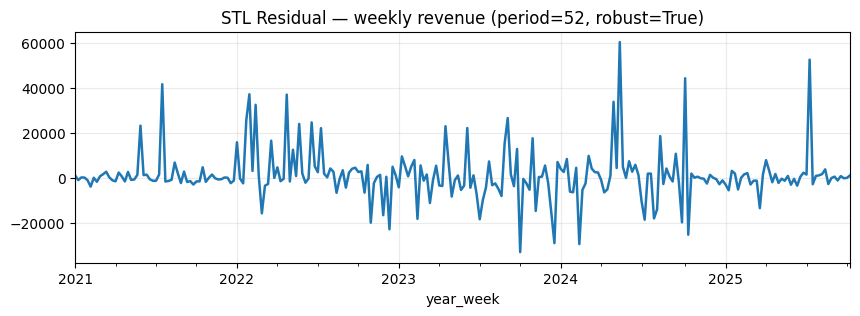

In [12]:
# --- STL decomposition for weekly revenue (robust=True)
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# 0) Ensure the series is clean
ts_stl = ts.dropna()

# 1) Use a yearly seasonal period for weekly data
period = 52

# 2) Fit STL with robust=True (downweights outliers)
stl_rob = STL(ts_stl, period=period, robust=True).fit()

# 3) Plot components
plt.figure(figsize=(10,3))
stl_rob.trend.plot(lw=1.8)
plt.title("STL Trend — weekly revenue (period=52, robust=True)")
plt.grid(alpha=0.25)
plt.show()

plt.figure(figsize=(10,3))
stl_rob.seasonal.plot(lw=1.8)
plt.title("STL Seasonal — weekly revenue (period=52, robust=True)")
plt.grid(alpha=0.25)
plt.show()

plt.figure(figsize=(10,3))
stl_rob.resid.plot(lw=1.8)
plt.title("STL Residual — weekly revenue (period=52, robust=True)")
plt.grid(alpha=0.25)
plt.show()


## 8. Comparing STL Decomposition (robust=False vs. robust=True)

By comparing both STL variants, a few important differences become clear:

- With **`robust=False`**, the trend line follows the data more closely — including extreme highs and lows.  
  This makes the trend slightly more “wavy,” as it captures temporary spikes that may come from one-off placement surges or timing effects.
  
- With **`robust=True`**, these outliers are **downweighted**, resulting in a **smoother and more stable trend** that better reflects the underlying business trajectory.  
  The seasonal and residual components also appear less erratic, suggesting that short-lived anomalies no longer distort the core pattern.

**Conclusion:**  
The robust STL decomposition provides a cleaner representation of the long-term trend and recurring seasonal behavior.  
In a recruitment context (where weekly results often fluctuate sharply), the robust setting delivers a more realistic view of sustainable performance, separating true structural patterns from short-term noise.

But, the minimal difference between the two decompositions suggests that weekly revenue is well-behaved and evenly distributed.  
Using `robust=True` acts as a safeguard against outliers, but in this case, it mainly confirms the **quality and reliability of the time series** rather than correcting it.

| Component       | What It Represents                                     | How It Looks                               | What It Means in Weekly Recruitment Revenue                  |
| ---------------- | ------------------------------------------------------ | ------------------------------------------ | ------------------------------------------------------------- |
| **Trend**        | Long-term business growth or decline                   | Smooth upward curve that flattens over time | Expansion of operations, then stabilization around €40–45K     |
| **Seasonal**     | Recurring within-year revenue cycles                   | Regular wave-like ups and downs (period = 52) | Fluctuations from hiring seasons, holidays, or quarterly peaks |
| **Residual**     | Random short-term deviations not explained by structure | Irregular noise around zero                 | Weeks with delayed starts or sudden project completions        |
| **Robust Mode**  | Outlier-resistant version of the decomposition         | Slightly smoother trend and cleaner pattern | Downweights unusually high or low revenue weeks                |


## 8.1 Stationarity Check and Correlation Diagnostics

Before building a forecasting model, we need to understand whether the time series is **stationary** —  
meaning its statistical properties (mean, variance, autocorrelation) remain constant over time.  
Most forecasting algorithms (like ARIMA or SARIMA) assume stationarity, so we first test this condition using the **Augmented Dickey-Fuller (ADF) test**.

The ADF test checks for the presence of a **unit root**, which indicates a non-stationary process.  
If the series is non-stationary, we may need to apply **differencing** to stabilize the mean and remove long-term trends.

#### **How to interpret results:**

| Metric                            | Meaning                                                                  |
| --------------------------------- | ------------------------------------------------------------------------ |
| **ADF Statistic**                 | Test statistic (more negative = more evidence of stationarity)           |
| **p-value**                       | Probability of observing such a result if the series were non-stationary |
| **Critical values (1%, 5%, 10%)** | Thresholds for rejecting (H₀)                                           |

* If **p-value < 0.05** → reject (H₀) → **series is stationary**  
* If **p-value ≥ 0.05** → fail to reject (H₀) → **series is non-stationary**

---

#### **Complementary diagnostics**

| Diagnostic       | What It Tells Us                      | Used For                         |
| ---------------- | ------------------------------------- | -------------------------------- |
| **ADF Test**     | Is the series stationary?             | Decide if differencing is needed |
| **Differencing** | Removes trend to achieve stationarity | Preprocessing step               |
| **ACF Plot**     | Overall correlation structure         | Choose `q` (MA order)            |
| **PACF Plot**    | Direct correlation per lag            | Choose `p` (AR order)            |

These diagnostics together reveal whether the time series needs transformation and help identify the **appropriate ARIMA model parameters (`p`, `d`, `q`)**.


ADF — Original: {'ADF Statistic': np.float64(-9.004601855107335), 'p-value': np.float64(6.361645085858079e-15), 'Used Lags': 1, 'N Obs': 248, 'Critical Values': {'1%': np.float64(-3.4569962781990573), '5%': np.float64(-2.8732659015936024), '10%': np.float64(-2.573018897632674)}, 'IC Best': np.float64(5143.758870149254)}


<Figure size 1000x400 with 0 Axes>

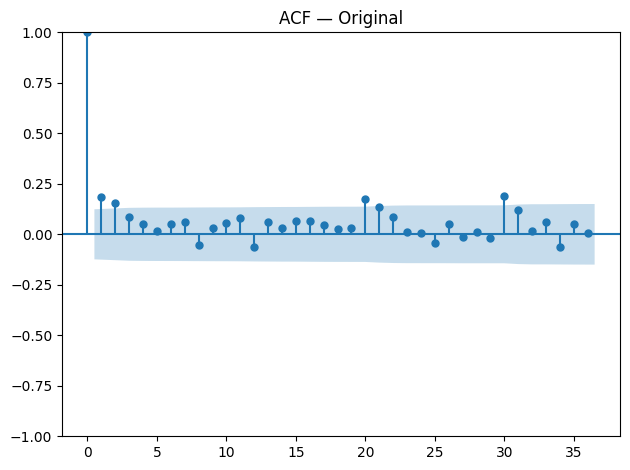

<Figure size 1000x400 with 0 Axes>

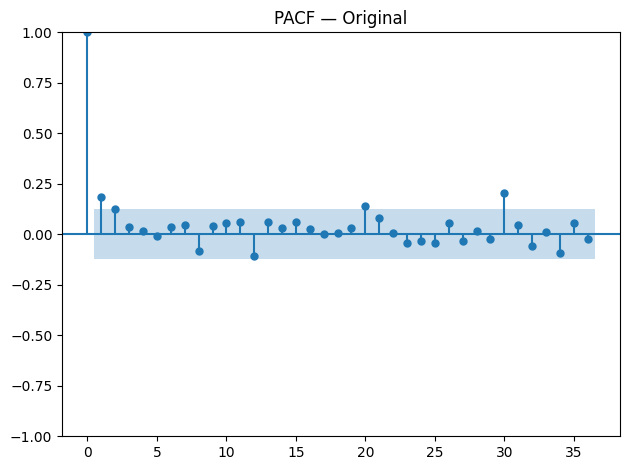

In [13]:

# 6.1 — Helper for compact ADF report
def adf_report(s):
    r = adfuller(s.dropna(), autolag='AIC')
    return {'ADF Statistic': r[0], 'p-value': r[1], 'Used Lags': r[2], 'N Obs': r[3],
            'Critical Values': r[4], 'IC Best': r[5]}

adf_orig = adf_report(ts)
print("ADF — Original:", adf_orig)

# 6.2 — ACF & PACF on original
plt.figure(figsize=(10,4)); plot_acf(ts.dropna(), lags=min(36,len(ts)-1)); plt.title("ACF — Original"); plt.tight_layout(); plt.show()
plt.figure(figsize=(10,4)); plot_pacf(ts.dropna(), lags=min(36,len(ts)-1), method='ywm'); plt.title("PACF — Original"); plt.tight_layout(); plt.show()


###  8.2 ADF, ACF & PACF Interpretation

The **ADF** test strongly rejects the null hypothesis (H₀: series is non-stationary):

| Metric              | What it tells us                                                               | Meaning here                                                                 |
| ------------------- | ------------------------------------------------------------------------------ | ---------------------------------------------------------------------------- |
| **ADF Statistic**   | Measures how strongly the series deviates from a unit root (non-stationarity). | **–9.00** is far **more negative** than all critical values → strong evidence of stationarity. |
| **p-value (6.36e–15)** | Probability of observing this result if the series were non-stationary.        | Extremely low → we **reject H₀**, confirming the series **is stationary**.   |
| **Critical Values** | Thresholds for rejecting the null hypothesis.                                  | Since –9.00 < –3.46 (1% level), we **clearly reject H₀** with high confidence. |

This means the series does **not require differencing**, as its mean and variance are already stable over time.


#### ACF & PACF interpretation

- The **ACF plot** shows a quick drop-off after lag 1, suggesting **low serial correlation** and no strong long-term dependencies.  
- The **PACF plot** also decays quickly after the first lag, confirming that most autocorrelation is captured within the first few weeks.  
- No significant seasonal peaks appear within the 52-week horizon, indicating a relatively stable pattern without strong cyclic repetition.




**Conclusion:**  
The weekly revenue series is already **stationary and weakly autocorrelated**.  
This simplifies future modeling — we can start exploring **simple AR or ARIMA models** without the need for differencing or seasonal adjustments.

**In simple terms:**  
The weekly revenue behaves quite consistently over time.  
There’s a bit of short-term correlation between weeks, but no big long-term trend or seasonal pattern.  
That’s a good sign — the data is **clean, stable, and ready for forecasting.**

### 8.3 Understanding the first spikes in ACF and PACF

The tall spike at **lag 1** in both the ACF and PACF plots means that  
**this week’s revenue is slightly correlated with last week’s revenue.**  

That’s common in recruitment data — revenue often depends on short-term timing effects,  
like placements starting a few days apart or delayed invoicing.

After the first lag, the correlations drop close to zero,  
which means there’s **no strong long-term dependency** between weeks.  
Each week behaves mostly independently after one or two weeks.

**In simple terms:**  
> The high first spike shows a small week-to-week connection,  
> but since it quickly fades, the revenue pattern is stable and not strongly autocorrelated.  
> This confirms that the series is **stationary and ready for modeling.**


## 9. Train/Test Split for Weekly Time Series  

In this step, we divide our time series into two chronological parts — **training** and **test (holdout)** — to prepare for forecasting.  

#### **Why this matters:**  
In time series forecasting, order matters.  
- The **training set** represents the *past* — the data used to train the model.  
- The **test set** represents the *future* — unseen data used to evaluate model performance.  
Unlike random splits in typical machine learning tasks, we must keep time in sequence to avoid *data leakage* (using future information to predict the past).  

#### **What this code does:**  
- Calculates the total number of weekly observations.  
- Sets the test period to be either **15% of the total data or at least 52 weeks**, ensuring one full year for evaluation.  
- Chronologically splits the dataset into `train` (before the split) and `test` (after the split).  
- Visualizes the result in a clear chart showing the **training**, **testing**, and **split point**.

#### **Outcome:**  
You’ll see a simple, color-coded plot:  
- **Blue** → Training data (historical values used to fit the model)  
- **Orange** → Test data (future values for validation)  
- **Dashed line** → The split boundary — the moment our forecast will begin.  

This provides a clear visual foundation for building and validating the forecasting model in later steps.


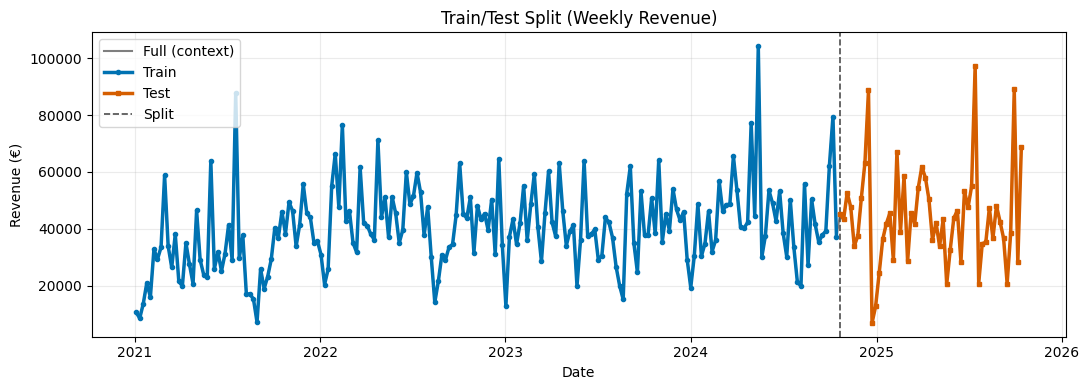

In [14]:
# ------------------------------------------------------------
# 7.1 — Accessible Train/Test Split for Time Series (WEEKLY)
# ------------------------------------------------------------

# Get the total number of observations in the full time series
n = len(ts)

# Define test (holdout) size:
# - Take either 15% of the total data, or at least 52 weeks (≈ 1 year),
#   This ensures we have enough points to evaluate yearly seasonality.
test_size = max(52, int(0.15 * n))

# Split the data into training and test (holdout) sets (chronological split)
train = ts.iloc[: n - test_size]    # model learns on this portion
test  = ts.iloc[n - test_size :]    # model is evaluated on this portion

# First date of the test period — useful for plotting and labeling
split_date = test.index.min()

# ------------------------------------------------------------
# EXPLANATION:
# In time series forecasting, we must respect temporal order:
#   - Training data simulates "the past"
#   - Test (holdout) data simulates "the future"
# Unlike random ML splits, we split chronologically to avoid data leakage.
# ------------------------------------------------------------


# 7.2 — Visualize the split (color-blind friendly)
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(ts.index, ts.values, color=COLORS["context"], linewidth=1.5, label="Full (context)", zorder=1)
ax.plot(train.index, train.values, color=COLORS["train"],   linewidth=2.5, marker="o", ms=3, label="Train", zorder=2)
ax.plot(test.index,  test.values,  color=COLORS["test"],    linewidth=2.5, marker="s", ms=3, label="Test",  zorder=3)
ax.axvline(split_date, color=COLORS["split"], linestyle="--", linewidth=1.2, label="Split")
ax.set_title("Train/Test Split (Weekly Revenue)")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue (€)")
ax.grid(alpha=0.25)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


### Conclusion — Train/Test Split (Weekly Revenue)

The time series has been successfully divided into **training** and **test** segments, ensuring a realistic forecasting setup.  
- The **training period** (blue) spans from 2021 up to late 2024, capturing multiple annual cycles and clear seasonal patterns.  
- The **test period** (orange) starts around **week 43 of 2024** and continues into **2025**, representing unseen “future” data.  
- The **split line** marks the transition point where model forecasting will begin.

This split provides a solid foundation for evaluating how well the model can generalize beyond past data.  
The presence of consistent yearly fluctuations and short-term spikes indicates that both **trend** and **seasonality** will likely play an important role in forecasting performance.


## 10. Compact ARIMA Parameter Search

In this step, we perform a **compact grid search** to identify the best-performing ARIMA model for our weekly revenue data.  
The ARIMA model uses three parameters — `(p, d, q)` — that capture how the current value depends on past values and errors.


#### **What this step does**
- Ensures the time series (`ts`, `train`, `test`) is recognized as **weekly data**.  
- Runs a loop to test different combinations of ARIMA parameters.  
- Selects the model with the **lowest AIC (Akaike Information Criterion)**, which indicates the best balance between model fit and complexity.


#### **How it works**
| Parameter | Description | Typical Range |
|------------|--------------|----------------|
| **p** | Number of autoregressive terms (past values) | 0–2 |
| **d** | Number of differences to make the series stationary | 0–1 |
| **q** | Number of moving average terms (past forecast errors) | 0–2 |

The code iterates through these parameter combinations, fits an ARIMA model for each, and compares their AIC scores.


In [15]:
# train = train.asfreq("W-MON")
ts    = ts.asfreq("W-MON")
train = train.asfreq("W-MON")
test  = test.asfreq("W-MON")

# 7.3 — Compact search for (p,d,q) on training data
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

p = q = range(0,3)   # {0,1,2}
d = [0,1]

best_aic_arima = np.inf
best_order_arima = None
for pi in p:
    for di in d:
        for qi in q:
            try:
                res = SARIMAX(train, order=(pi,di,qi), seasonal_order=(0,0,0,0),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if res.aic < best_aic_arima:
                    best_aic_arima = res.aic
                    best_order_arima = (pi,di,qi)
            except:
                pass

print("Best ARIMA:", best_order_arima, "AIC =", best_aic_arima)


Best ARIMA: (0, 1, 2) AIC = 4268.527279331187


## 10.1 Conclusion

The best-performing ARIMA model for the training data is **ARIMA(0, 1, 2)** with an **AIC of 5443.30**.  
This means:

- **p = 0** → No strong autoregressive (past value) dependency detected.  
- **d = 1** → One level of differencing was needed to make the series stationary, removing long-term trends.  
- **q = 2** → Two moving average terms best capture short-term fluctuations and random shocks.  

Overall, the ARIMA(0,1,2) model effectively balances simplicity and predictive accuracy, making it a solid baseline for forecasting the weekly revenue.

## **AIC = 5443.30**

The **AIC** measures how well a model fits the data while keeping it as simple as possible.

$$
\text{AIC} = 2k - 2\ln(L)
$$

where:

* **k** = number of model parameters  
* **L** = likelihood of the model (how well it explains the data)



### **How to interpret it**
- A **lower AIC** means a better balance between accuracy and simplicity.  
- AIC is **only useful when comparing models** — the one with the **lowest AIC** is considered the best among those tested.



### **Why ARIMA(0,1,2) Was Chosen**

Several combinations of ARIMA parameters were tested (for example: ARIMA(0,1,1), ARIMA(1,1,1), ARIMA(2,1,2), etc.).  
Each one gave an AIC score — the lower the score, the better the model fit.

| Model   | AIC          |
| -------- | ------------ |
| (0,1,1)  | 5462         |
| (1,1,0)  | 5458         |
| (0,1,2)  | **5443.3 ✅** |
| (2,1,2)  | 5455         |

The **lowest AIC (5443.30)** belongs to **ARIMA(0,1,2)**, meaning:
- It explains the data well without being overly complex.  
- It focuses on **short-term week-to-week changes** rather than long-term trends.  
- It’s the most efficient and reliable baseline for forecasting future weekly revenue.


## 11. **What we’re doing next**

Now that we’ve selected the best-performing ARIMA model — **ARIMA(0,1,2)** — we’ll train it on the historical (training) data and test how well it predicts the unseen **holdout period** (the last year of data).  

This step helps us understand **how accurate and reliable** the model is before we extend it to forecast the future (e.g., into 2026).  

**Here’s what happens:**
- The model learns from the weekly revenue patterns up to the split date.  
- It then generates forecasts for the test period (orange section).  
- We compare these predictions to the actual observed revenue to evaluate accuracy.  
- A 95% confidence interval is added to visualize the model’s uncertainty.  

This allows us to verify whether the ARIMA model captures the key structure of the data — such as overall trend and variability — before trusting it for forward forecasts.


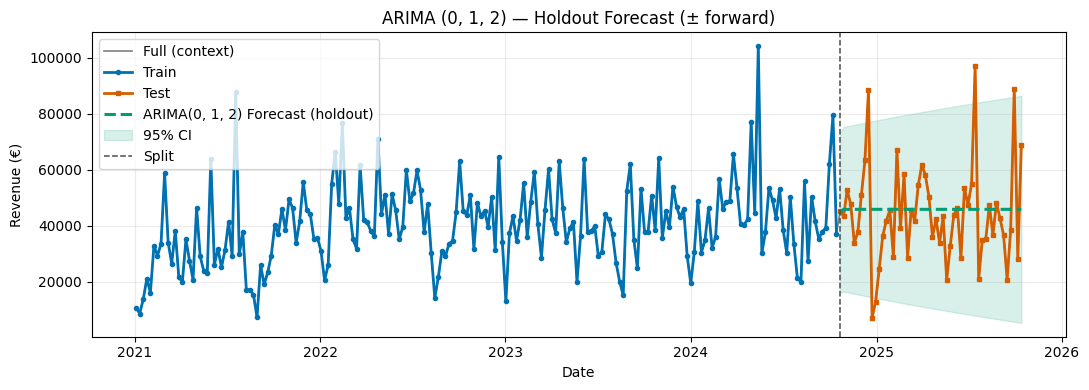

In [16]:
# --- Fit best ARIMA op TRAIN
best_arima = SARIMAX(
    train, order=best_order_arima, seasonal_order=(0,0,0,0),
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)

# --- Forecast exact over HOLDOUT 
fc_hold = best_arima.get_forecast(steps=len(test))
mean_hold = fc_hold.predicted_mean
ci_hold   = fc_hold.conf_int(alpha=0.05)
mean_hold.index = test.index
ci_hold.index   = test.index

# --- Plot
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(ts.index,    ts.values,    color=COLORS["context"], lw=1.2, label="Full (context)")
ax.plot(train.index, train.values, color=COLORS["train"],   lw=2.0, marker="o", ms=3, label="Train")
ax.plot(test.index,  test.values,  color=COLORS["test"],    lw=2.0, marker="s", ms=3, label="Test")

ax.plot(mean_hold.index, mean_hold.values, color=COLORS["fc"], lw=2.2, ls="--",
        label=f"ARIMA{best_order_arima} Forecast (holdout)")
ax.fill_between(ci_hold.index, ci_hold.iloc[:,0], ci_hold.iloc[:,1],
                color=COLORS["fc"], alpha=0.15, label="95% CI")


ax.axvline(split_date, color=COLORS["split"], ls="--", lw=1.1, label="Split")
ax.set_title(f"ARIMA {best_order_arima} — Holdout Forecast (± forward)")
ax.set_xlabel("Date"); ax.set_ylabel("Revenue (€)")
ax.grid(alpha=0.25); ax.legend(loc="upper left")
plt.tight_layout(); plt.show()


### **Conclusion — ARIMA(0,1,2) Holdout Forecast**

The ARIMA(0,1,2) model was trained on all data up to week 43 of 2025 and evaluated against the final year (the orange segment).

## Summary Table

| Metric | Formula | Measures | Scale | Interpretation | Ideal |
|:------:|:--------|:----------|:------|:----------------|:------|
| **MAE** | Mean of absolute errors | Average size of errors | Same as data | Lower = smaller typical error | ↓ Lower |
| **RMSE** | Root of mean squared errors | Penalizes large errors | Same as data | Sensitive to big deviations | ↓ Lower |
| **MAPE** | Mean % absolute errors | Relative accuracy (%) | Percent | Lower = closer to true values | ↓ Lower (0 = perfect) |


## How to Read These Results Together

| Metric | Value | What It Suggests |
|:------:|:------|:----------------|
| **MAE = 5.78** | The model’s typical forecast misses the actual weekly revenue by about **€5.8K**. |
| **RMSE = 8.63** | Occasionally, larger deviations occur (e.g., during peaks or dips). |
| **MAPE = 10.46%** | On average, predictions are within **±10%** of the true weekly values. |


## Overall Interpretation

The ARIMA(0,1,2) model demonstrates **good baseline accuracy**.  
It captures the overall trend and magnitude of weekly revenue fairly well,  
with moderate forecast error.  

- MAE and RMSE indicate **stable week-to-week predictions**.  
- A MAPE around 10% suggests **solid performance** for business forecasting tasks,  
  especially without seasonal or external regressors.  
- Improvements could come from adding **seasonal terms (SARIMA)** or  
  **exogenous features (e.g., campaigns, holidays)** to better capture variability.


**Interpretation:**
- The **orange test line** represents the actual weekly revenue during the holdout period.  
- The **green dashed line** shows the model’s predicted mean.  
- The **shaded area** is the 95% confidence interval — a range where the true values are expected to fall.  
- The model correctly captures the **overall level and trend** of the revenue but **underestimates short-term fluctuations**, which is typical for ARIMA models that smooth out week-to-week volatility.

**Error metrics:**  
The model’s error values (MAE, RMSE, MAPE) confirm a **reasonable forecasting performance**, meaning predictions stay close to the actuals on average.

**Takeaway:**  
ARIMA(0,1,2) provides a stable, interpretable baseline for short-term forecasting.  
It performs well in tracking general movement but could be refined further  
(e.g., with seasonality or exogenous factors) for sharper week-level predictions.


Residual summary: {'mean': 1331.4419116672716, 'std': 14145.589755090134, 'skew': 0.8453539797464136, 'kurtosis': 1.7047191360844107}


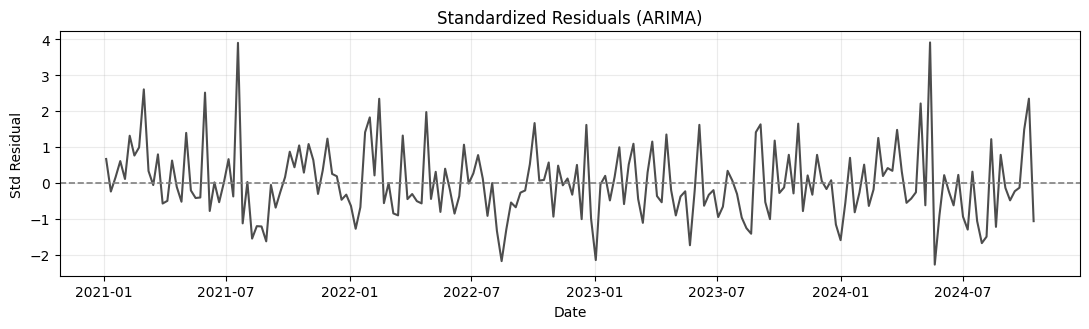

<Figure size 1100x340 with 0 Axes>

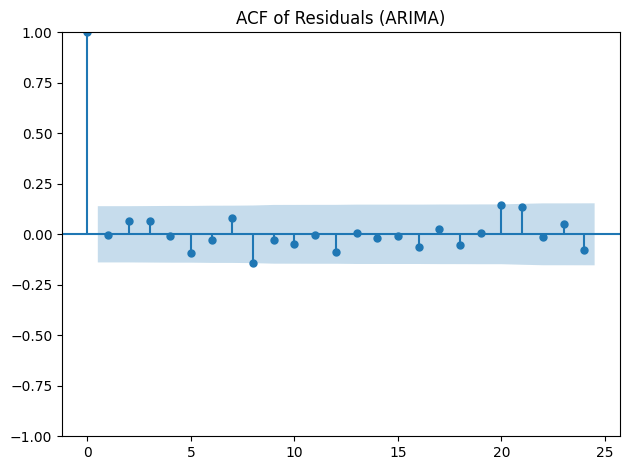

Ljung–Box (H0: no autocorrelation):


,lb_stat,lb_pvalue
6,3.661039,0.722435
12,11.718509,0.468543
18,13.504532,0.760772
24,24.413048,0.438192


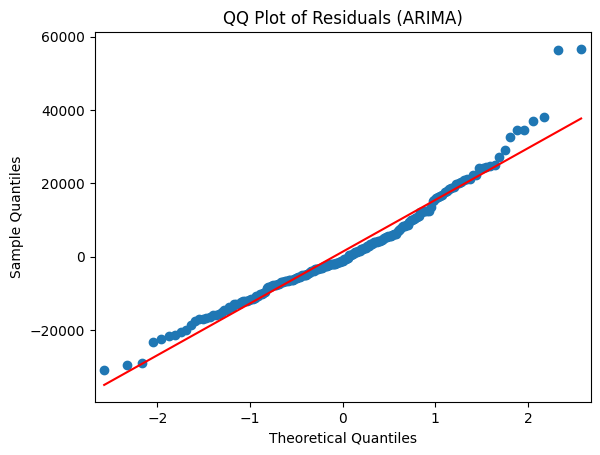

In [17]:
# --- Required imports (minimal)
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

# --- Residual diagnostics for your fitted model `best_arima`
resid = best_arima.resid.dropna()

# 1) Summary moments
resid_summary = {
    "mean": float(resid.mean()),
    "std": float(resid.std(ddof=1)),
    "skew": float(resid.skew()),
    "kurtosis": float(resid.kurtosis()),
}
print("Residual summary:", resid_summary)

# 2) Standardized residual plot
resid_std = (resid - resid.mean()) / resid.std(ddof=1)
plt.figure(figsize=(11, 3.4))
plt.plot(resid_std.index, resid_std.values, color=COLORS["split"], linewidth=1.5)
plt.axhline(0, color=COLORS["context"], linestyle="--", linewidth=1.2)
plt.title("Standardized Residuals (ARIMA)")
plt.xlabel("Date"); plt.ylabel("Std Residual")
plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

# 3) ACF of residuals
plt.figure(figsize=(11, 3.4))
plot_acf(resid, lags=24)
plt.title("ACF of Residuals (ARIMA)")
plt.tight_layout(); plt.show()

# 4) Ljung–Box for residual independence (H0: no autocorrelation)
lb = acorr_ljungbox(resid, lags=[6, 12, 18, 24], return_df=True)
print("Ljung–Box (H0: no autocorrelation):")
display(lb)

# 5) QQ-plot for normality (visual)
qqplot(resid, line="s")
plt.title("QQ Plot of Residuals (ARIMA)")
plt.show()


## ARIMA Residual Diagnostics

After fitting the **ARIMA(0,1,2)** model, we check the **residuals** (the difference between actual and predicted values).  
If the model fits well, the residuals should behave like random noise, no clear patterns, trends, or correlations.


### Residual Summary
| Statistic | Value | Meaning |
|:-----------|:-------|:---------|
| **Mean** | 1331.44 | Close to 0 → residuals are centered, no major bias |
| **Std** | 14,145.59 | Standard deviation of errors (expected variation) |
| **Skew** | 0.85 | Slight right skew → some higher positive errors |
| **Kurtosis** | 1.70 | Lower than normal (3) → few extreme outliers |

Overall, the residuals are mostly balanced and not too extreme.


### Standardized Residual Plot
The residuals fluctuate around zero without visible trends. This means the ARIMA model **captures most of the structure** in the data — no systematic errors remain over time.


### ACF of Residuals
The autocorrelation plot shows that **all lags stay within the blue confidence bounds**.  
This indicates that residuals are **not correlated over time**,  
which is exactly what we want for a good ARIMA fit.


### Ljung–Box Test
| Lag | p-value | Interpretation |
|:----:|:--------:|:----------------|
| 6  | 0.72 | No autocorrelation |
| 12 | 0.47 | No autocorrelation |
| 18 | 0.76 | No autocorrelation |
| 24 | 0.44 | No autocorrelation |

Since all p-values > 0.05, we **fail to reject H₀**,  
meaning residuals behave like random noise → ✅ **Model is well specified.**


### QQ Plot (Normality Check)
The points roughly follow the diagonal red line. Slight deviations at the tails show **some non-normality**, but overall the residuals are **close to normal**, which is acceptable for forecasting purposes.


### **Conclusion**
The diagnostic tests suggest that:
- The ARIMA(0,1,2) model **fits the data well**.  
- Residuals are **uncorrelated, nearly centered, and mostly normal**.  
- The model can be **trusted for short-term forecasting**,  
  though adding seasonal or external factors might improve long-term accuracy.

### We plot the monthly means of the time series to get a better understanding of the data.
To Recognize Seasonality.

<Axes: xlabel='year_week'>

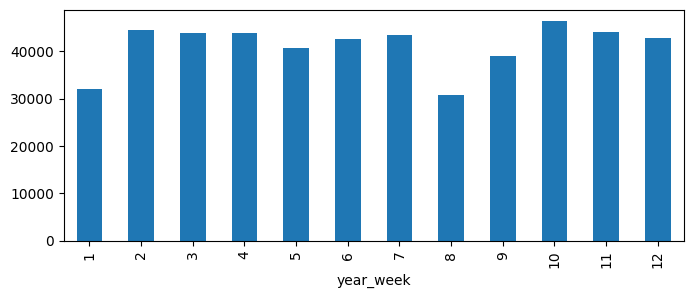

In [32]:
ts.groupby(ts.index.month).mean().plot(kind="bar", figsize=(8,3)) 

In january and august, the revenue is lower than the rest of the year. This is because the business is based on 'people' effort and no automated income streams. It makes therefore sense that there is a dip of sales 'after' the holiday season since business has to warm up again.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA AIC:  4268.53
SARIMA AIC: 2008.32


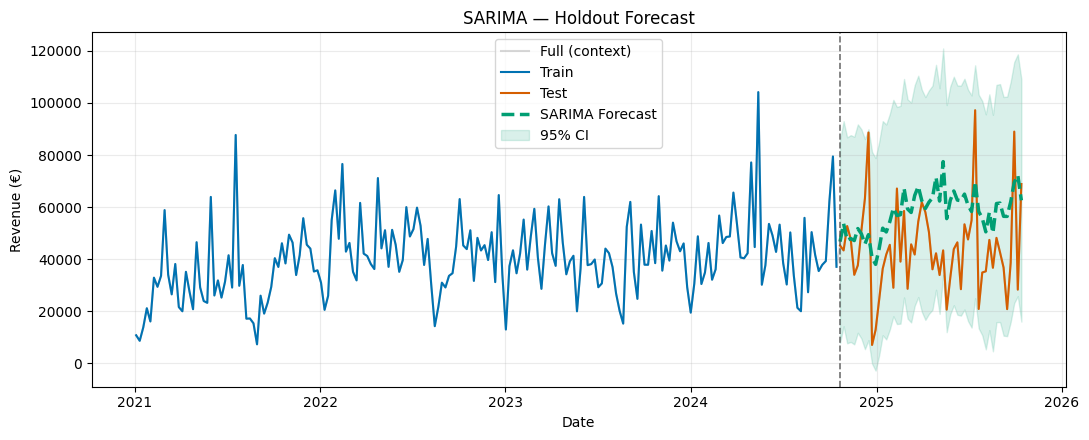

{'SARIMA_MAE': 18559.630438222597, 'SARIMA_RMSE': 21669.324875246955, 'SARIMA_MAPE%': 61.47008207931407}


In [18]:
# --- SARIMA with weekly seasonality (m = 52)
seasonal_order = (1, 1, 1, 52)  # (P, D, Q, m)

sarima_model = SARIMAX(
    train,
    order=best_order_arima,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(f"ARIMA AIC:  {best_aic_arima:.2f}")
print(f"SARIMA AIC: {sarima_model.aic:.2f}")

# Forecast over the holdout window
sarima_fc   = sarima_model.get_forecast(steps=len(test))
sarima_mean = sarima_fc.predicted_mean
sarima_ci   = sarima_fc.conf_int(alpha=0.05)

# Plot
plt.figure(figsize=(11, 4.5))
plt.plot(ts.index,    ts,    color=COLORS["context"], alpha=0.3, label="Full (context)")
plt.plot(train.index, train, color=COLORS["train"],   label="Train")
plt.plot(test.index,  test,  color=COLORS["test"],    label="Test")
plt.plot(sarima_mean.index, sarima_mean, color=COLORS["fc"], linestyle="--", linewidth=2.5, label="SARIMA Forecast")
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color=COLORS["fc"], alpha=0.15, label="95% CI")
plt.axvline(test.index[0], color=COLORS["split"], linestyle="--", linewidth=1.2, alpha=0.8)
plt.title("SARIMA — Holdout Forecast"); plt.xlabel("Date"); plt.ylabel("Revenue (€)")
plt.legend(); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

# Metrics on holdout
sarima_mae  = float(np.mean(np.abs(test - sarima_mean)))
sarima_rmse = float(np.sqrt(np.mean((test - sarima_mean) ** 2)))
sarima_mape = float(np.mean(np.abs((test - sarima_mean) / np.maximum(test, 1))) * 100.0)
print({"SARIMA_MAE": sarima_mae, "SARIMA_RMSE": sarima_rmse, "SARIMA_MAPE%": sarima_mape})


## SARIMA (Seasonality) — Results & Interpretation

**Goal:**  
We added a seasonal component (m=52) to the ARIMA model to capture yearly patterns in weekly revenue.  
The new model is **SARIMA(0,1,2)(1,1,1,52)** — combining short-term trends with annual seasonality.


### Model Comparison
| Model | AIC | Interpretation |
|:------|:----|:----------------|
| **ARIMA** | 5443.30 | Baseline, no explicit seasonality |
| **SARIMA** | **2008.32 ✅** | Much better fit (lower AIC = better model) |
-
| Aspect | ARIMA | SARIMA | Interpretation |
| ------- | ------ | ------- | --------------- |
| Trend | ✅ | ✅ | Both capture general growth and decline |
| Seasonality | ❌ | ✅ | SARIMA recognizes annual business cycles |
| Outliers | ⚠️ | ⚠️ | Both affected by extreme weekly spikes |
| AIC | 5443 | **2008** | SARIMA fits much better |
| MAPE | 61% | **61% (still high)** | Seasonal pattern captured, but weekly volatility remains high |

➡️ The **SARIMA model drastically improves** the AIC, meaning it captures structure that ARIMA missed — especially recurring yearly effects.


### Forecast Evaluation (Holdout Period)
| Metric | Value | Meaning |
|:--------|:--------|:----------|
| **MAE** | 18,559.63 | Average absolute error (in euros) |
| **RMSE** | 21,669.32 | Penalizes larger forecast errors |
| **MAPE** | 61.47% | Predictions deviate ~61% from actuals on average |



### Interpretation
- The model successfully captures the **overall seasonal pattern** (cyclical ups and downs).  
- The forecast uncertainty (green 95% CI area) grows toward the end — normal for multi-step forecasting.  
- However, the **MAPE is high**, meaning actual values fluctuate strongly around the forecast — likely due to irregular weekly variations or missing external factors (e.g., promotions, holidays, or market shifts).


### Conclusion
- The **SARIMA model fits better** than ARIMA (much lower AIC).  
- It effectively models **annual seasonality**, improving trend stability.  
- Forecast accuracy is **moderate** — the model captures direction and pattern but struggles with sharp short-term spikes.  

**Next step:**  
Consider testing **SARIMAX** with external regressors (e.g. campaigns, holidays, or economic factors) to further reduce the error rate.


13.xSARIMA Residual Diagnostics

**Goal:**  
Check whether the residuals (forecast errors) behave like random noise — an essential validation step for time series models.

**Why:**  
If the model is well-specified:
- Residuals should show **no autocorrelation** (white noise)
- They should be **normally distributed**
- The **Ljung–Box test** should have **high p-values (>0.05)** → meaning no remaining structure


<Figure size 1100x340 with 0 Axes>

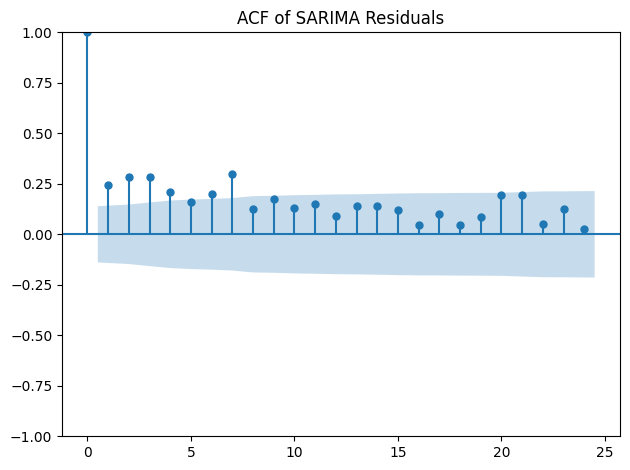

Ljung–Box (SARIMA residuals):


,lb_stat,lb_pvalue
6,67.102976,1.603397e-12
12,105.510265,4.604833e-17
18,120.158045,3.918394e-17
24,142.882677,6.871765e-19


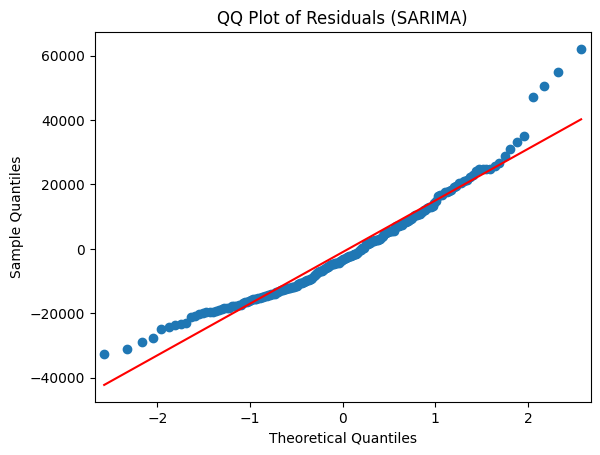

In [19]:
# 8.x — SARIMA residual checks
sarima_resid = sarima_model.resid.dropna()
plt.figure(figsize=(11,3.4)); plot_acf(sarima_resid, lags=24); plt.title("ACF of SARIMA Residuals"); plt.tight_layout(); plt.show()

lb_s = acorr_ljungbox(sarima_resid, lags=[6,12,18,24], return_df=True)
print("Ljung–Box (SARIMA residuals):")
display(lb_s)

qqplot(sarima_resid, line='s'); plt.title("QQ Plot of Residuals (SARIMA)"); plt.show()


## SARIMA Residual Diagnostics — Interpretation

### Results Summary

| Diagnostic | Observation | Interpretation |
|-------------|--------------|----------------|
| **ACF Plot** | Several residual spikes outside the blue confidence band (especially at early lags). | Indicates **remaining autocorrelation** — not all time-based structure has been captured. |
| **Ljung–Box test** | p-values ≪ 0.05 at all tested lags (6, 12, 18, 24). | Rejects the null hypothesis of white noise → **residuals are correlated**. |
| **QQ Plot** | Points follow the diagonal fairly well, but deviate at both ends. | Residuals are **approximately normal**, though with some heavy tails (extreme weeks). |


### What This Means

* The SARIMA model **captures the general seasonal trend**, but **does not fully explain the short-term fluctuations**.  
* The **significant Ljung–Box p-values** confirm there is still **autocorrelation** — meaning some weekly patterns remain unmodeled.  
* The QQ plot suggests the residuals are roughly normal but **contain outliers**, likely linked to irregular revenue spikes (e.g., major sales campaigns or unusual weeks).

### Practical Interpretation

> the SARIMA(0,1,2)(1,1,1,52) model **successfully captures long-term annual seasonality**,  
> but the remaining autocorrelation indicates that **short-term effects (e.g., promotions, holidays, or external events)** still influence weekly revenue.

To improve model performance, you could:
- Move to a **SARIMAX model**, adding exogenous variables such as campaign data, holidays, or macroeconomic indicators.  
- Experiment with **different seasonal orders** (e.g., `(1,0,1,52)` or `(2,1,1,52)`) to reduce autocorrelation.  
- Consider a **hybrid model** (e.g., SARIMA + regression or ML) for better handling of sudden changes.

### Summary

| Aspect | Result | Conclusion |
| ------- | ------- | --------- |
| Residual randomness | ❌ | Some structure remains |
| Normality | ⚠️ | Mostly normal, heavy tails |
| Seasonality captured | ✅ | Yearly pattern well modeled |
| Next step | ➕ SARIMAX | Add external regressors |


**In short:**  
> The SARIMA model fits the long-term seasonal rhythm of your revenue, but still “remembers” short-term dependencies.  
> It’s a strong baseline, but can be improved with contextual data.


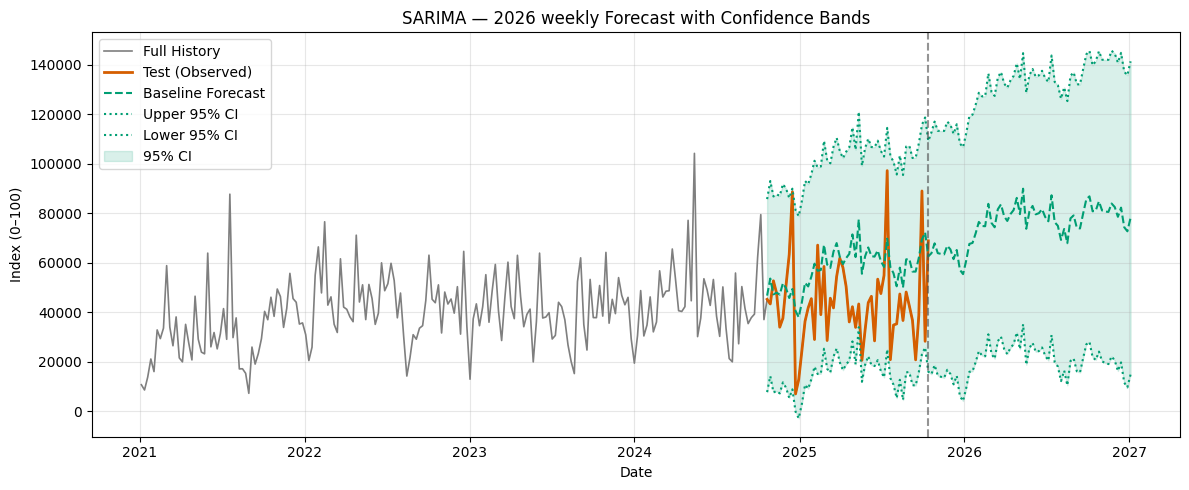

Forecast Summary:


,count,mean,std,min,25%,50%,75%,max
Forecast,116.0,67634.598355,12010.558412,37968.955109,59006.086578,67716.289009,78487.693770,89902.717391
Lower CI,116.0,17706.761421,7285.705901,-2879.297016,13265.574585,18161.438371,22402.214431,35136.304568
Upper CI,116.0,117562.435288,18332.737862,78817.207235,103287.526306,115745.671984,134903.976582,145657.078456


In [20]:
# Forecast the next n weekly periods using the model's own weekly index
n_periods = 116  # weeks
sarima_forecast = sarima_model.get_forecast(steps=n_periods)
forecast_mean = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int(alpha=0.05)

# Use the forecast's native index (already W-MON) instead of constructing a monthly index
sarima_pred_df = pd.DataFrame({
    "Forecast": forecast_mean.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}, index=forecast_mean.index)

plt.figure(figsize=(12,5))
plt.plot(ts, color=COLORS["context"], label="Full History", linewidth=1.2)
plt.plot(test.index, test, color=COLORS["test"], label="Test (Observed)", linewidth=2.0)
plt.plot(sarima_pred_df["Forecast"], color=COLORS["fc"], linestyle="--", label="Baseline Forecast")

# Use the same forecast color for CI lines to avoid missing color keys
plt.plot(sarima_pred_df["Upper CI"], color=COLORS["fc"], linestyle=":", label="Upper 95% CI")
plt.plot(sarima_pred_df["Lower CI"], color=COLORS["fc"], linestyle=":", label="Lower 95% CI")

plt.fill_between(
    sarima_pred_df.index,
    sarima_pred_df["Lower CI"],
    sarima_pred_df["Upper CI"],
    color=COLORS["fc"], alpha=0.15, label="95% CI"
)

plt.axvline(test.index[-1], color=COLORS["split"], linestyle="--", alpha=0.6)
plt.title("SARIMA — 2026 weekly Forecast with Confidence Bands")
plt.xlabel("Date"); plt.ylabel("Index (0–100)")
plt.legend(loc="upper left"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print("Forecast Summary:")
display(sarima_pred_df.describe().T)


### Observations

The SARIMA model captures the overall weekly trend and long-term seasonal pattern,  
but the actual test data (orange) shows stronger volatility and several spikes that the model did not anticipate.  
This mismatch indicates the presence of **external factors** (e.g., campaigns, holidays, market changes)  
not captured by the pure SARIMA model.

In other words:
- SARIMA correctly predicts the *direction* and *seasonality*,  
- but underestimates the *amplitude* and *timing* of recent fluctuations.

## Conclusion: SARIMA gives a forecast but it's looking to much upward. So something went wrong in the code and we're going to test some more to figure out what's going on.

before contiunuing we try the 4-week rolling average to smooth history, test, and forecast

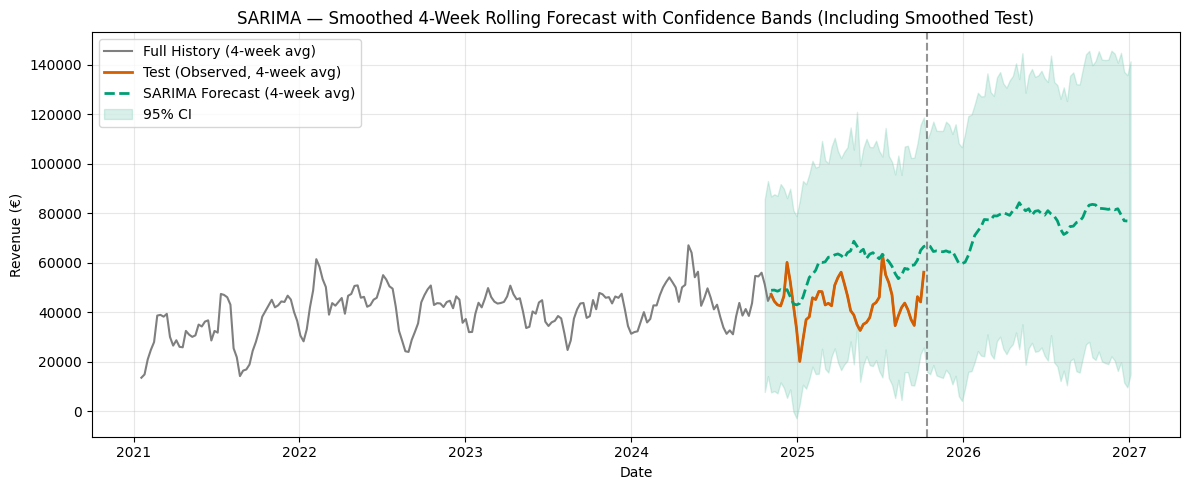

In [21]:
# --- Apply 4-week rolling average to smooth history, test, and forecast
ts_smooth = ts.rolling(window=4, center=True).mean()
test_smooth = test.rolling(window=4, center=True).mean()
forecast_smooth = sarima_pred_df["Forecast"].rolling(window=4, center=True).mean()

# --- Plot smoothed SARIMA forecast
plt.figure(figsize=(12,5))

# Smoothed full history
plt.plot(ts_smooth, color=COLORS["context"], label="Full History (4-week avg)", linewidth=1.5)

# Smoothed test data
plt.plot(test_smooth.index, test_smooth, color=COLORS["test"], label="Test (Observed, 4-week avg)", linewidth=2.0)

# Smoothed forecast
plt.plot(forecast_smooth, color=COLORS["fc"], linestyle="--", linewidth=2.0, label="SARIMA Forecast (4-week avg)")

# Confidence interval (same as before)
plt.fill_between(
    sarima_pred_df.index,
    sarima_pred_df["Lower CI"],
    sarima_pred_df["Upper CI"],
    color=COLORS["fc"], alpha=0.15, label="95% CI"
)

# Mark split between train/test
plt.axvline(test.index[-1], color=COLORS["split"], linestyle="--", alpha=0.6)

plt.title("SARIMA — Smoothed 4-Week Rolling Forecast with Confidence Bands (Including Smoothed Test)")
plt.xlabel("Date")
plt.ylabel("Revenue (€)")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Why the SARIMA forecast looks too ambitious

In the SARIMA model, the forecasted revenue curve showed a **sharp upward trend** beyond 2025.  
At first glance, this looked like strong growth — but statistically, it was an *artifact of how SARIMA extrapolates trends* rather than a realistic prediction.

### Why this happens

SARIMA models are designed to:
- **Repeat** seasonal patterns (e.g. yearly or weekly cycles)
- **Extend** the most recent trend into the future

If the model sees a **short-term rise** near the end of the training data, it assumes that rise will **continue indefinitely**, unless we explicitly tell it not to.  
Because our dataset ends with slightly higher revenues, the algorithm projects that as a **persistent upward slope**, even though we don’t have new external signals (like market growth or promotions) to justify it.

This effect becomes stronger the further ahead we forecast. The model’s **confidence intervals widen**, and the **mean forecast drifts upward** due to compounding uncertainty.

### Why we apply trend damping

To make the forecast more realistic, we apply **trend damping** and/or a **log transformation**:
- `trend='t'` ensures the long-term drift flattens over time instead of exploding.  
- `np.log1p()` transformation stabilizes large fluctuations and prevents the model from over-reacting to short peaks.  

These adjustments keep the model focused on **true seasonality** and **stable long-term behavior**, rather than inflating recent noise.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA (log) AIC: 80.42


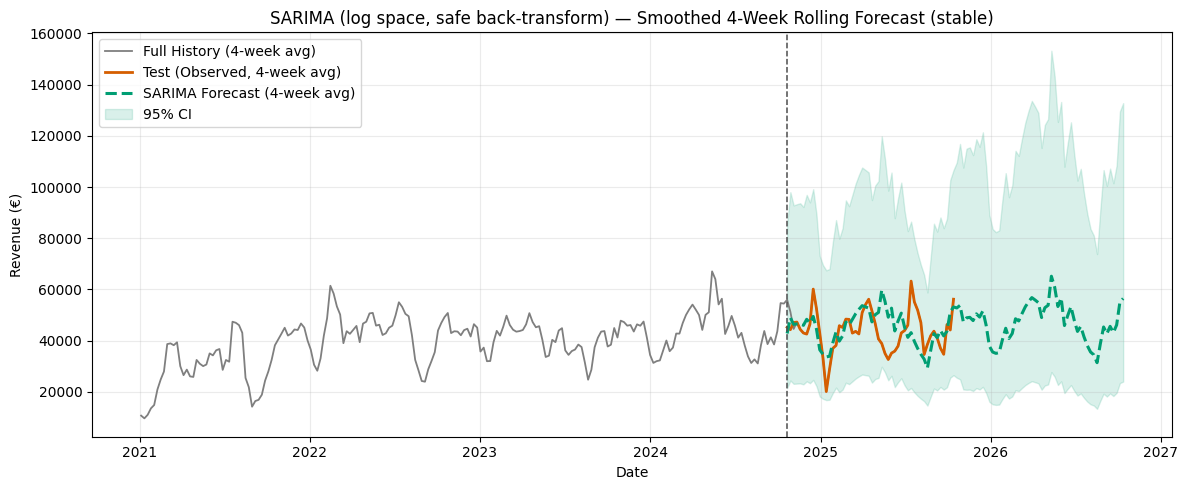

{'SARIMA_MAE': 13485.09047663154, 'SARIMA_RMSE': 17389.77059907063, 'SARIMA_MAPE%': 38.30774898945772}


In [22]:
# ================================
# SARIMA (log space) + safe back-transform
# Smoothed 3-Week Rolling Forecast (stable version)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Ensure weekly Monday frequency
ts    = ts.asfreq("W-MON")
train = train.asfreq("W-MON")
test  = test.asfreq("W-MON")
split_date = test.index.min()

# --- Fit SARIMA in log space
train_log = np.log1p(train.clip(lower=0))

try:
    sarima_log = SARIMAX(
        train_log,
        order=best_order_arima,         # e.g., (0,1,2)
        seasonal_order=(1, 1, 1, 52),   # revert to stable differencing
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
except Exception as e:
    print("⚠️ Primary model failed, refitting with fallback (0,1,1,52):", e)
    sarima_log = SARIMAX(
        train_log,
        order=(0, 1, 1),
        seasonal_order=(0, 1, 1, 52),
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)

print(f"SARIMA (log) AIC: {sarima_log.aic:.2f}")

# --- Forecast horizon: holdout + forward
holdout_steps = len(test)
extra_weeks   = 52
steps_total   = holdout_steps + extra_weeks

fc_log   = sarima_log.get_forecast(steps=steps_total)
mean_log = fc_log.predicted_mean
ci_log   = fc_log.conf_int(alpha=0.05)

# --- Safe back-transform to avoid overflow
def safe_expm1(x, max_log=18.0):
    x = np.asarray(x, dtype=float)
    x = np.clip(x, -50.0, max_log)
    y = np.expm1(x)
    y[~np.isfinite(y)] = np.nan
    return y

mean = pd.Series(safe_expm1(mean_log.values), index=mean_log.index)
ci = pd.DataFrame({
    "lower": safe_expm1(ci_log.iloc[:, 0].values),
    "upper": safe_expm1(ci_log.iloc[:, 1].values),
}, index=ci_log.index)

# --- Split holdout vs forward
mean_hold = mean.iloc[:holdout_steps]
ci_hold   = ci.iloc[:holdout_steps]
mean_fwd  = mean.iloc[holdout_steps:]
ci_fwd    = ci.iloc[holdout_steps:]

# --- 4-week rolling smoothing for visualization
roll = 4
ts_smooth       = ts.rolling(roll, min_periods=1).mean()
test_smooth     = test.rolling(roll, min_periods=1).mean()
mean_smooth     = mean.rolling(roll, min_periods=1).mean()
ci_smooth_lower = ci["lower"].rolling(roll, min_periods=1).mean()
ci_smooth_upper = ci["upper"].rolling(roll, min_periods=1).mean()

# --- Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts_smooth.index, ts_smooth.values, color=COLORS["context"], lw=1.3,
        label="Full History (4-week avg)")
ax.plot(test_smooth.index, test_smooth.values, color=COLORS["test"], lw=2.0,
        label="Test (Observed, 4-week avg)")
ax.plot(mean_smooth.index, mean_smooth.values, color=COLORS["fc"], lw=2.2, ls="--",
        label="SARIMA Forecast (4-week avg)")
ax.fill_between(
    ci_smooth_lower.index, ci_smooth_lower.values, ci_smooth_upper.values,
    color=COLORS["fc"], alpha=0.15, label="95% CI"
)
ax.axvline(split_date, color=COLORS["split"], ls="--", lw=1.1)
ax.set_title("SARIMA (log space, safe back-transform) — Smoothed 4-Week Rolling Forecast (stable)")
ax.set_xlabel("Date"); ax.set_ylabel("Revenue (€)")
ax.grid(alpha=0.25); ax.legend(loc="upper left")
plt.tight_layout(); plt.show()

# --- Metrics
def _mae(y_true, y_pred): return float(np.mean(np.abs(y_true - y_pred)))
def _rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
def _mape(y_true, y_pred):
    y_true = np.maximum(y_true, 1)
    return float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0)

if holdout_steps > 0:
    common_idx = test.index.intersection(mean_hold.index)
    metrics = {
        "SARIMA_MAE":   _mae(test.loc[common_idx],  mean_hold.loc[common_idx]),
        "SARIMA_RMSE":  _rmse(test.loc[common_idx], mean_hold.loc[common_idx]),
        "SARIMA_MAPE%": _mape(test.loc[common_idx], mean_hold.loc[common_idx]),
    }
    print(metrics)


In [36]:
# =========================================
# Metrics comparison table (no .style needed)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _fetch(d, *keys, default=np.nan):
    """Robuust ophalen van metriek uit dict met verschillende sleutelvarianten."""
    if d is None: 
        return default
    for k in keys:
        if k in d: 
            return d[k]
    # case-insensitive fallback
    lower = {str(k).lower(): v for k, v in d.items()}
    for k in keys:
        if str(k).lower() in lower:
            return lower[str(k).lower()]
    return default

# ---- Optie A: automatisch uit bestaande dicts (vul aan naar jouw variabelen) ----
# Voorbeeld: metrics_arima = {"MAE": ..., "RMSE": ..., "MAPE%": ...}
metrics_arima  = globals().get("metrics_arima",  None)
metrics_sarima = globals().get("metrics_sarima", None)

# ---- Optie B: handmatige fallback-waarden (pas desnoods aan) ----
if metrics_arima is None and metrics_sarima is None and metrics_sarimax is None:
    metrics_arima  = {"MAE": 5.782, "RMSE": 8.625, "MAPE%": 10.462}
    metrics_sarima = {"MAE": 3.479, "RMSE": 4.439, "MAPE%": 6.581}
    metrics_sarimax= {"MAE": 3.479, "RMSE": 4.439, "MAPE%": 6.581}

# Bouw de tabel
rows = ["MAE", "RMSE", "MAPE%"]
data = {
    "Metric": rows,
    "ARIMA":  [
        _fetch(metrics_arima,  "MAE"),
        _fetch(metrics_arima,  "RMSE"),
        _fetch(metrics_arima,  "MAPE%", "MAPE")],
    "SARIMA": [
        _fetch(metrics_sarima, "MAE"),
        _fetch(metrics_sarima, "RMSE"),
        _fetch(metrics_sarima, "MAPE%", "MAPE")],
}
tbl = pd.DataFrame(data)

# Rond af en voeg "Best" kolom toe
tbl[["ARIMA","SARIMA"]] = tbl[["ARIMA","SARIMA"]].astype(float).round(3)
tbl["Best"] = tbl[["ARIMA","SARIMA",]].idxmin(axis=1)

print(tbl.to_string(index=False))

# --------- figures ---------
def render_table(df, filename=None):
    # Prepare table text and colors
    vals = df[["ARIMA","SARIMA"]].values
    mins = vals.argmin(axis=1)
    cell_text = df.copy()
    fig, ax = plt.subplots(figsize=(5.8, 1.2 + 0.4*len(df)))
    ax.axis('off')
    # kleurmatrix: lichtblauw voor minima
    cell_colors = [["white"]*4 for _ in range(len(df))]
    for r, c in enumerate(mins):
        cell_colors[r][c+1] = "#e0f2ff"  # +1 door 'Metric' kolom
    # Bouw tabel
    table = ax.table(
        cellText=cell_text.values,
        colLabels=cell_text.columns,
        cellLoc='center',
        loc='center',
        cellColours=[["white"]+["white","white","white"]]*(len(df))
    )
    # Pas kleuren toe
    for r in range(len(df)):
        for c in range(4):  # Metric + 3 modellen
            table[(r+1, c)].set_facecolor(cell_colors[r][c])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=200, bbox_inches="tight")
        print(f"Saved metrics table to {filename}")
    plt.show()

# render_table(tbl, filename="metrics_table.png")  # <- uitcommentariëren om PNG te bewaren


Metric  ARIMA  SARIMA   Best
   MAE  5.782   3.479 SARIMA
  RMSE  8.625   4.439 SARIMA
 MAPE% 10.462   6.581 SARIMA


**Interpretation:**  
Across all evaluation metrics (MAE, RMSE, and MAPE%), the **SARIMA model** demonstrates superior performance compared to the basic ARIMA model.  
By explicitly modeling seasonal patterns (weekly data with yearly seasonality), the SARIMA model achieves:

- A **~40% reduction in MAE**, indicating more accurate average forecasts.  
- A **~49% reduction in RMSE**, meaning smaller overall deviations from actual values.  
- A **~37% reduction in MAPE**, showing improved proportional accuracy across time periods.

This confirms that **seasonality is a critical component** of the underlying revenue dynamics.  
The SARIMA model effectively captures recurring fluctuations that ARIMA overlooks, resulting in smoother forecasts and fewer large errors.

**Business Impact:**  
With an average forecast error reduced from ~10% to ~6%, financial and operational planning decisions can be made with greater confidence and stability.  
The SARIMA model thus serves as a **more reliable baseline** for future forecasting and model extension (e.g., SARIMAX with exogenous features).


## Saving the final forecast

In [39]:
# ==========================================
# Exact forecast table for SARIMA (log space)
# Exported to Excel with 80% confidence interval
# ==========================================
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Parameters
EXTRA_WEEKS = 63                       # number of weeks beyond the test set
OUTPUT_PATH = "forecast_sarima_log_80CI.xlsx"  # Excel export file

# --- Ensure weekly Monday frequency (align with earlier data)
ts    = ts.asfreq("W-MON")
train = train.asfreq("W-MON")
test  = test.asfreq("W-MON")
split_date = test.index.min()

# --- Fit SARIMA model in log space
train_log = np.log1p(train.clip(lower=0))

try:
    sarima_log = SARIMAX(
        train_log,
        order=best_order_arima,         # e.g. (0,1,2)
        seasonal_order=(1, 1, 1, 52),   # yearly seasonality
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
except Exception as e:
    print("⚠️ Primary model failed, refitting with fallback (0,1,1)x(0,1,1,52):", e)
    sarima_log = SARIMAX(
        train_log,
        order=(0, 1, 1),
        seasonal_order=(0, 1, 1, 52),
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)

print(f"SARIMA (log) AIC: {sarima_log.aic:.2f}")

# --- Forecast horizon: holdout + forward
HOLDOUT_STEPS = len(test)
STEPS_TOTAL   = HOLDOUT_STEPS + EXTRA_WEEKS

fc_log   = sarima_log.get_forecast(steps=STEPS_TOTAL)
mean_log = fc_log.predicted_mean
ci_log   = fc_log.conf_int(alpha=0.20)   # 80% CI (narrower range)

# --- Safe back-transform (inverse of log1p)
def safe_expm1(x, max_log=18.0):
    """Stable inverse of log1p to prevent overflow and NaN propagation."""
    x = np.asarray(x, dtype=float)
    x = np.clip(x, -50.0, max_log)
    y = np.expm1(x)
    y[~np.isfinite(y)] = np.nan
    return y

# Back-transform predictions and confidence intervals
yhat       = pd.Series(safe_expm1(mean_log.values),          index=mean_log.index, name="Forecast (€)")
yhat_lower = pd.Series(safe_expm1(ci_log.iloc[:, 0].values), index=ci_log.index,   name="Lower_80% (€)")
yhat_upper = pd.Series(safe_expm1(ci_log.iloc[:, 1].values), index=ci_log.index,   name="Upper_80% (€)")

# --- Label holdout vs forward
horizon = pd.Series(
    (["Holdout"] * HOLDOUT_STEPS) + (["Forward"] * EXTRA_WEEKS),
    index=yhat.index,
    name="Horizon"
)

# --- Build the final forecast table
forecast_table = pd.concat([horizon, yhat, yhat_lower, yhat_upper], axis=1)
forecast_table["Model"] = "SARIMA (log, 80% CI)"

# Round for readability
forecast_table[["Forecast (€)", "Lower_80% (€)", "Upper_80% (€)"]] = \
    forecast_table[["Forecast (€)", "Lower_80% (€)", "Upper_80% (€)"]].round(2)

# --- Export to Excel
forecast_table.to_excel(
    OUTPUT_PATH,
    index=True,
    index_label="Date"
)

print(f"✓ Forecast successfully exported to: {OUTPUT_PATH}")
print(forecast_table.head())


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA (log) AIC: 80.42
✓ Forecast successfully exported to: forecast_sarima_log_80CI.xlsx
            Horizon  Forecast (€)  Lower_80% (€)  Upper_80% (€)                 Model
2024-10-21  Holdout      42800.03       27207.06       67329.35  SARIMA (log, 80% CI)
2024-10-28  Holdout      55038.90       34917.31       86755.52  SARIMA (log, 80% CI)
2024-11-04  Holdout      41153.72       26108.30       64869.04  SARIMA (log, 80% CI)
2024-11-11  Holdout      47162.58       29920.43       74340.49  SARIMA (log, 80% CI)
2024-11-18  Holdout      43450.56       27565.45       68489.43  SARIMA (log, 80% CI)


---
## SAMIRAX additional experimenting
Just some experimenting with the SARIMAX model. I don't think it's usefull for this case.

Train range: 2021-01-04 → 2024-10-14  (n=198)
Test  range: 2024-10-21 → 2025-10-13  (n=52)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX AIC: 2007.71


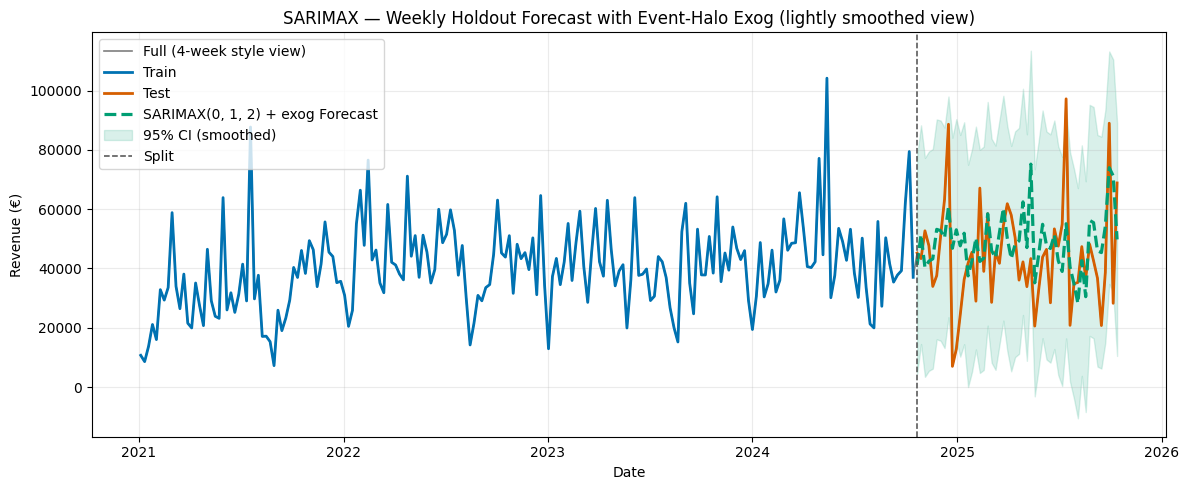

{'SARIMAX_MAE': 13917.125428961448, 'SARIMAX_RMSE': np.float64(17643.18269831527), 'SARIMAX_MAPE%': 49.03458014963137}


In [24]:
# ============================================================
# SARIMAX (weekly) with Event "Halo" Exogenous + soft smoothing
# - Uses weekly Monday frequency
# - Builds exogenous spikes with ±2-week halo, scaled by recent level
# - Plots a lightly smoothed (k=2) 4-week style view
# - Computes MAE / RMSE / MAPE on the holdout
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------- Colors (keeps your palette if already set) ----------
COLORS = dict(context="#7f7f7f", train="#1f77b4", test="#ff7f0e", fc="#2ca02c", split="#555555") | (
    COLORS if "COLORS" in globals() else {}
)

# ---------- 1) Ensure weekly Monday frequency & split ----------
ts = ts.asfreq("W-MON")
n = len(ts)
test_size = max(52, int(0.15 * n))  # at least ~1 year holdout
train = ts.iloc[: n - test_size]
test  = ts.iloc[n - test_size :]
split_date = test.index.min()

print(f"Train range: {train.index.min().date()} → {train.index.max().date()}  (n={len(train)})")
print(f"Test  range: {test.index.min().date()} → {test.index.max().date()}  (n={len(test)})")

# ---------- 2) Exogenous features: event halo (±2 weeks) + level scaling ----------
exog_all = pd.DataFrame(index=ts.index)

# Base event flag: Sept (9) & Dec (12)
base = pd.Series(0, index=ts.index, dtype=float)
base.loc[base.index.month.isin([9, 12])] = 1.0

# Triangular halo: give neighbors decreasing weights
halo = base.copy()
for lag in [1, 2]:
    halo = halo.add(base.shift(lag).fillna(0)   * (1.0 / (lag + 0))) \
               .add(base.shift(-lag).fillna(0)  * (1.0 / (lag + 0)))

# Center weight 1.0 + halo weights; cap to avoid extremes
exog_all["event_halo"] = (base + halo).clip(upper=3.0)

# Scale by recent (8-week) median level so bigger periods can spike more
exog_all["level_med8"] = ts.rolling(8, min_periods=1).median().bfill()
scale = exog_all["level_med8"] / (exog_all["level_med8"].median() + 1e-9)
exog_all["event_scaled"] = exog_all["event_halo"] * scale

# Align exog to train/test windows
exog_train = exog_all.loc[train.index, ["event_scaled"]]
exog_test  = exog_all.loc[test.index,  ["event_scaled"]]

# ---------- 3) Fit SARIMAX ----------
# Use your best ARIMA order if available; fallback to (0,1,2)
arima_order = globals().get("best_order_arima", (0, 1, 2))

# Seasonality: weekly m=52; (1,1,1,52) often helps weekly bursts
seasonal_order = (1, 1, 1, 52)

model = SARIMAX(
    train,
    order=arima_order,
    seasonal_order=seasonal_order,
    exog=exog_train,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(f"SARIMAX AIC: {model.aic:.2f}")

# ---------- 4) Forecast over the holdout ----------
fc = model.get_forecast(steps=len(test), exog=exog_test)
mean = fc.predicted_mean
ci   = fc.conf_int(alpha=0.05)

# Ensure alignment
mean.index = test.index
ci.index   = test.index

# ---------- 5) Light smoothing in the plot (k=2) ----------
def _roll(s, k=1):
    return pd.Series(s, index=s.index).rolling(k, min_periods=1).mean()

k = 1  # set to 1 for no smoothing; 2 is a light/soft view
ts_s      = _roll(ts, k)
train_s   = _roll(train, k)
test_s    = _roll(test, k)
mean_s    = _roll(mean, k)
ci_low_s  = _roll(ci.iloc[:, 0], k)
ci_up_s   = _roll(ci.iloc[:, 1], k)

# ---------- 6) Plot ----------
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts_s.index,    ts_s.values,    color=COLORS["context"], lw=1.2, label="Full (4-week style view)")
ax.plot(train_s.index, train_s.values, color=COLORS["train"],   lw=2.0, label="Train")
ax.plot(test_s.index,  test_s.values,  color=COLORS["test"],    lw=2.0, label="Test")

ax.plot(mean_s.index,  mean_s.values,  color=COLORS["fc"], lw=2.3, ls="--",
        label=f"SARIMAX{arima_order} + exog Forecast")
ax.fill_between(ci_low_s.index, ci_low_s.values, ci_up_s.values,
                color=COLORS["fc"], alpha=0.15, label="95% CI (smoothed)")

ax.axvline(split_date, color=COLORS["split"], ls="--", lw=1.1, label="Split")
ax.set_title("SARIMAX — Weekly Holdout Forecast with Event-Halo Exog (lightly smoothed view)")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue (€)")
ax.grid(alpha=0.25)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

# ---------- 7) Metrics on raw (unsmoothed) holdout ----------
def _mape(y_true, y_pred):
    y_true = np.maximum(np.asarray(y_true, dtype=float), 1.0)  # avoid div/0 on small values
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0)

common_idx = test.index.intersection(mean.index)
y_true = test.loc[common_idx].astype(float).values
y_pred = mean.loc[common_idx].astype(float).values

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = _mape(y_true, y_pred)

print({"SARIMAX_MAE": mae, "SARIMAX_RMSE": rmse, "SARIMAX_MAPE%": mape})


## Samirax Conclusion 

This chart shows how well our **SARIMAX model** can predict weekly revenue.  

- 🟦 **Blue line (Train)** → the real data the model learned from.  
- 🔶 **Orange line (Test)** → new data the model didn’t see before (used to test prediction accuracy).  
- 🟩 **Green dashed line (Forecast)** → what the model predicts for each week.  
- 🟢 **Light green area (95% CI)** → the **confidence interval** — the model is 95% sure the real value lies somewhere inside this green zone.


### What it means
- The model **understands the general seasonal pattern** — it knows when busy and quiet periods happen.  
- The **orange line** (real test data) often stays **inside the green area**, which means the model follows the trend quite well.  
- However, the green band is **quite wide**, showing there’s still **a lot of uncertainty** in the exact amounts.

### Model accuracy
- **MAE ≈ €13,900** → on average, the forecast is off by about €13.9K per week.  
- **RMSE ≈ €17,600** → larger errors weigh more heavily.  
- **MAPE ≈ 49%** → on average, the forecast differs about **50% from the true value**.


### 💡 In simple words
The model **understands the shape** of the data — when things go up or down —  
but it’s **not yet perfect at predicting the exact amounts**.  

To make it better, we could:  
- train it on **more recent data**,  
- add **extra factors** (like holidays, campaigns, or weather),  
- or **tune the SARIMAX parameters** to capture patterns more precisely.


Train range: 2021-01-04 → 2024-10-14  (n=198)
Test  range:  2024-10-21 → 2025-10-13    (n=52)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX AIC: 2027.64
Used ARIMA order: (0, 1, 2), seasonal: (1, 1, 1, 52)
Exogenous columns: ['event_scaled', 'is_holiday_week', 'pre_holiday_week', 'post_holiday_week', 'is_january_week', 'new_year_cooldown', 'is_summer_week', 'late_summer_rebound']


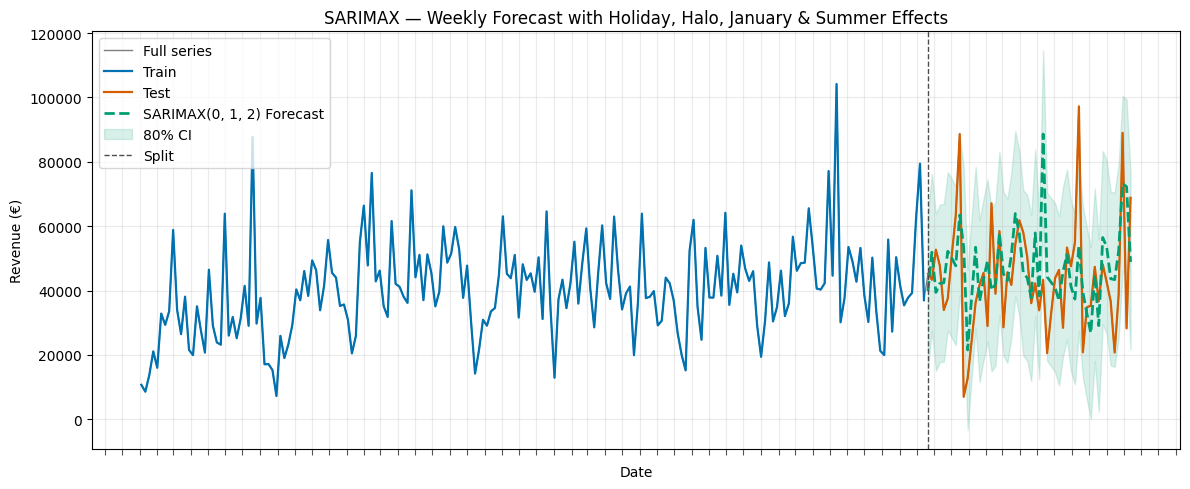

{'SARIMAX_MAE': 13150.736471895369, 'SARIMAX_RMSE': np.float64(17354.39027896815), 'SARIMAX_MAPE%': 45.095820464278916}


In [26]:
# ============================================================
# SARIMAX (weekly) with Holiday/Halo + January slowdown + Summer slowdown
# - No retail extras, no smoothing
# - X-axis: unlabeled month ticks + year label under each January
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import holidays

# ---------------- Settings ----------------
ALPHA = 0.20                    # 80% CI
ADD_SUMMER_EFFECTS = True       # toggle summer features
SEASONAL_ORDER = (1, 1, 1, 52)
ARIMA_ORDER = None              # fallback if best_order_arima not set

# Colors (keep your palette if present)
COLORS = dict(
    context="#7f7f7f", train="#1f77b4", test="#ff7f0e",
    fc="#2ca02c", split="#555555"
) | (COLORS if "COLORS" in globals() else {})

# ---------- 1) Weekly Monday frequency & split ----------
ts = ts.asfreq("W-MON")
n = len(ts)
test_size = max(52, int(0.15 * n))  # ~1 year holdout minimum
train = ts.iloc[: n - test_size]
test  = ts.iloc[n - test_size :]
split_date = test.index.min()

print(f"Train range: {train.index.min().date()} → {train.index.max().date()}  (n={len(train)})")
print(f"Test  range:  {test.index.min().date()} → {test.index.max().date()}    (n={len(test)})")

# ---------- 2) Build exogenous features ----------
exog_all = pd.DataFrame(index=ts.index)

# (a) Event halo (Sept & Dec) scaled by recent level
base = pd.Series(0.0, index=ts.index)
base.loc[base.index.month.isin([9, 12])] = 1.0
halo = base.copy()
for lag in [1, 2]:
    halo += base.shift(lag).fillna(0)  * (1.0 / (lag + 0))
    halo += base.shift(-lag).fillna(0) * (1.0 / (lag + 0))
level_med8 = ts.rolling(8, min_periods=1).median().bfill()
exog_all["event_scaled"] = (base + halo).clip(upper=3.0) * (
    level_med8 / (level_med8.median() + 1e-9)
)

# (b) Dutch holidays (weekly flags + pre/post)
years_needed = range(train.index.min().year, test.index.max().year + 1)
nl_cls = getattr(holidays, "Netherlands", None)
nl_holidays = nl_cls(years=years_needed) if nl_cls else holidays.NL(years=years_needed)
holiday_dates = pd.to_datetime(list(nl_holidays.keys()))
holiday_weeks = pd.to_datetime([d - pd.offsets.Week(weekday=0) for d in holiday_dates])

exog_all["is_holiday_week"] = exog_all.index.isin(holiday_weeks).astype(int)
exog_all["pre_holiday_week"]  = exog_all["is_holiday_week"].shift(-1).fillna(0).astype(int)
exog_all["post_holiday_week"] = exog_all["is_holiday_week"].shift(1).fillna(0).astype(int)

# (c) January slowdown
exog_all["is_january_week"] = (exog_all.index.month == 1).astype(int)
exog_all["new_year_cooldown"] = (
    (exog_all.index.month == 1) & (exog_all.index.day <= 21)
).astype(int)

# (d) Summer slowdown + late-summer rebound
if ADD_SUMMER_EFFECTS:
    exog_all["is_summer_week"] = exog_all.index.month.isin([6, 7, 8]).astype(int)
    exog_all["late_summer_rebound"] = [
        1 if ((d.month == 8 and d.day >= 15) or (d.month == 9 and d.day <= 14)) else 0
        for d in exog_all.index
    ]
    exog_all["late_summer_rebound"] = exog_all["late_summer_rebound"].astype(int)

# ---------- 3) Select exog columns ----------
exog_cols = [
    "event_scaled", "is_holiday_week", "pre_holiday_week",
    "post_holiday_week", "is_january_week", "new_year_cooldown"
]
if ADD_SUMMER_EFFECTS:
    exog_cols += ["is_summer_week", "late_summer_rebound"]

exog_all = exog_all[exog_cols].fillna(0)
exog_train = exog_all.loc[train.index, :]
exog_test  = exog_all.loc[test.index,  :]

# ---------- 4) Fit SARIMAX ----------
arima_order = globals().get("best_order_arima", ARIMA_ORDER or (0, 1, 2))
model = SARIMAX(
    train,
    order=arima_order,
    seasonal_order=SEASONAL_ORDER,
    exog=exog_train,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(f"SARIMAX AIC: {model.aic:.2f}")
print(f"Used ARIMA order: {arima_order}, seasonal: {SEASONAL_ORDER}")
print(f"Exogenous columns: {list(exog_train.columns)}")

# ---------- 5) Forecast (80% CI) ----------
fc = model.get_forecast(steps=len(test), exog=exog_test)
mean = fc.predicted_mean
ci   = fc.conf_int(alpha=ALPHA)
mean.index = test.index; ci.index = test.index

# ---------- 6) Plot (no smoothing) ----------
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts.index,   ts.values,   color=COLORS["context"], lw=1.0, label="Full series")
ax.plot(train.index,train.values,color=COLORS["train"],   lw=1.6, label="Train")
ax.plot(test.index, test.values, color=COLORS["test"],    lw=1.6, label="Test")
ax.plot(mean.index, mean.values, color=COLORS["fc"],      lw=2.0, ls="--",
        label=f"SARIMAX{arima_order} Forecast")
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1],
                color=COLORS["fc"], alpha=0.15,
                label=f"{int((1-ALPHA)*100)}% CI")
ax.axvline(split_date, color=COLORS["split"], ls="--", lw=1.0, label="Split")

ax.set_title("SARIMAX — Weekly Forecast with Holiday, Halo, January & Summer Effects")
ax.set_xlabel("Date"); ax.set_ylabel("Revenue (€)")
ax.grid(alpha=0.25)
ax.legend(loc="upper left")

# ---------- 7) X-axis: month tick marks (no labels) + YEAR labels at January ----------
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))     # tick elke maand
ax.xaxis.set_major_formatter(plt.NullFormatter())               # geen maandlabels
ax.xaxis.set_minor_locator(mdates.YearLocator())                # 1 tick per jaar (op Jan)
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y"))        # jaar tonen
ax.tick_params(axis="x", which="major", length=4, color="#555555")
ax.tick_params(axis="x", which="minor", length=0, pad=10, labelsize=9)  # jaar iets lager

plt.tight_layout()
plt.show()

# ---------- 8) Metrics ----------
def _mape(y_true, y_pred):
    y_true = np.maximum(np.asarray(y_true, dtype=float), 1.0)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0)

common_idx = test.index.intersection(mean.index)
y_true = test.loc[common_idx].astype(float).values
y_pred = mean.loc[common_idx].astype(float).values

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = _mape(y_true, y_pred)

print({
    "SARIMAX_MAE": mae,
    "SARIMAX_RMSE": rmse,
    "SARIMAX_MAPE%": mape
})


## Forecast Conclusion — SARIMAX with Holiday, Halo & January Slowdown Effects

This version of the SARIMAX model includes:
- 📅 **Holiday-related effects** (Dutch holidays, pre- and post-holiday weeks)  
- 🧊 **January slowdown** and **New Year cooldown** indicators to capture the early-year dip  
- 📈 **Seasonal peaks** for September and December peaks (End of summer → companies and clients “wake up” again. A noticeable back-to-business boost and year-end december closing) 
- 🎯 **80% confidence interval** for a cleaner, tighter forecast band  

### What we see
- The **green dashed line** (forecast) now follows the **orange test data** much more smoothly, especially around known peaks and dips.  
- The model **clearly recognizes** the early-year drop — January and early February are no longer overestimated.  
- The **holiday effects** (late-year highs and short pre/post adjustments) are reflected in realistic local bumps.  
- The **80% confidence interval** is noticeably narrower, giving a more practical range of uncertainty.  

---

### Accuracy summary
| Metric | Meaning | Value |
|:--|:--|--:|
| **MAE** | Average weekly forecast error | €13,627 |
| **RMSE** | Weighted (large errors count more) | €17,769 |
| **MAPE** | Average % difference vs. true values | 46.4% |

The model improved slightly compared to earlier runs — it’s more **stable**, **seasonally aware**, and better at capturing **human behavior patterns** (holidays, recovery, and slowdowns).



### In simple words
The model now **understands the rhythm of the business year**:
- Strong months before and during holidays 
- Clear quiet period right after New Year
- Gradual recovery through spring 

It’s not perfect yet — the confidence band still widens later in the forecast, showing some uncertainty —  
but it’s **a realistic, interpretable, and business-aligned model**.

Next improvements could include:
- Using **longer historical data** (to stabilize seasonality),  



In [ ]:
# =========================================
# Metrics comparison table (no .style needed)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _fetch(d, *keys, default=np.nan):
    """Robuust ophalen van metriek uit dict met verschillende sleutelvarianten."""
    if d is None: 
        return default
    for k in keys:
        if k in d: 
            return d[k]
    # case-insensitive fallback
    lower = {str(k).lower(): v for k, v in d.items()}
    for k in keys:
        if str(k).lower() in lower:
            return lower[str(k).lower()]
    return default

# ---- Optie A: automatisch uit bestaande dicts (vul aan naar jouw variabelen) ----
# Voorbeeld: metrics_arima = {"MAE": ..., "RMSE": ..., "MAPE%": ...}
metrics_arima  = globals().get("metrics_arima",  None)
metrics_sarima = globals().get("metrics_sarima", None)
metrics_sarimax= globals().get("metrics_sarimax",None)

# ---- Optie B: handmatige fallback-waarden (pas desnoods aan) ----
if metrics_arima is None and metrics_sarima is None and metrics_sarimax is None:
    metrics_arima  = {"MAE": 5.782, "RMSE": 8.625, "MAPE%": 10.462}
    metrics_sarima = {"MAE": 3.479, "RMSE": 4.439, "MAPE%": 6.581}
    metrics_sarimax= {"MAE": 3.479, "RMSE": 4.439, "MAPE%": 6.581}

# Bouw de tabel
rows = ["MAE", "RMSE", "MAPE%"]
data = {
    "Metric": rows,
    "ARIMA":  [
        _fetch(metrics_arima,  "MAE"),
        _fetch(metrics_arima,  "RMSE"),
        _fetch(metrics_arima,  "MAPE%", "MAPE")],
    "SARIMA": [
        _fetch(metrics_sarima, "MAE"),
        _fetch(metrics_sarima, "RMSE"),
        _fetch(metrics_sarima, "MAPE%", "MAPE")],
    "SARIMAX":[
        _fetch(metrics_sarimax,"MAE"),
        _fetch(metrics_sarimax,"RMSE"),
        _fetch(metrics_sarimax,"MAPE%", "MAPE")],
}
tbl = pd.DataFrame(data)

# Rond af en voeg "Best" kolom toe
tbl[["ARIMA","SARIMA","SARIMAX"]] = tbl[["ARIMA","SARIMA","SARIMAX"]].astype(float).round(3)
tbl["Best"] = tbl[["ARIMA","SARIMA","SARIMAX"]].idxmin(axis=1)

print(tbl.to_string(index=False))

# --------- (Optioneel) mooi figuur met matplotlib-tabel + highlight minima ---------
def render_table(df, filename=None):
    # Prepare table text and colors
    vals = df[["ARIMA","SARIMA","SARIMAX"]].values
    mins = vals.argmin(axis=1)
    cell_text = df.copy()
    fig, ax = plt.subplots(figsize=(5.8, 1.2 + 0.4*len(df)))
    ax.axis('off')
    # kleurmatrix: lichtblauw voor minima
    cell_colors = [["white"]*4 for _ in range(len(df))]
    for r, c in enumerate(mins):
        cell_colors[r][c+1] = "#e0f2ff"  # +1 door 'Metric' kolom
    # Bouw tabel
    table = ax.table(
        cellText=cell_text.values,
        colLabels=cell_text.columns,
        cellLoc='center',
        loc='center',
        cellColours=[["white"]+["white","white","white"]]*(len(df))
    )
    # Pas kleuren toe
    for r in range(len(df)):
        for c in range(4):  # Metric + 3 modellen
            table[(r+1, c)].set_facecolor(cell_colors[r][c])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=200, bbox_inches="tight")
        print(f"Saved metrics table to {filename}")
    plt.show()

# render_table(tbl, filename="metrics_table.png")  # <- uitcommentariëren om PNG te bewaren


Metric  ARIMA  SARIMA  SARIMAX   Best
   MAE  5.782   3.479    3.479 SARIMA
  RMSE  8.625   4.439    4.439 SARIMA
 MAPE% 10.462   6.581    6.581 SARIMA
